# Are SAT Scores a Fair Test for All Students?

### For this analysis, we will be using the New York City published data on student SAT scores by high school along with other demographic datasets to answer the following questions:

* <b>Which fields from the data have a high correlation with SAT scores?<br/>
<br/>
* For those fields with high correlation with SAT scores: are their other patterns we can find as we deep dive into those correlations?<br/>
<br/>
* Does race, economic wellfare, district, or any other demographic play a role in SAT scores?</b>

### In our analysis we will be using a combined pandas dataframe that includes the following datasets:

* <b>SAT scores by school</b> - SAT scores for each high school in New York City
* <b>School attendance</b> - Attendance information for each school in New York City
* <b>Class size</b> - Information on class size for each school
* <b>AP test results</b> - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* <b>Graduation outcomes</b> - The percentage of students who graduated, and other outcome information
* <b>Demographics</b> - Demographic information for each school
* <b>School survey</b> - Surveys of parents, teachers, and students at each school

## Summary of Final Analysis/Conclusion of Student Demographics/Survey Catagories vs. SAT Scores:

+ There is a clear negative relationship between ELL, FRL, Black, and Hispanic students and the SAT scores.
+ On average, Asian and White students have an advantage over Black and Hispanic students when it comes to SAT scores in NYC.
+ Schools with the highest SAT scores are ones with between 40-75% female student body, or between 30-70% male student body
+ Both ELL and race (namely Asian and Hispanic) play a role in average SAT scores for schools.
+ While ELL overall negatively correlates with SAT, Asian ELL students tend to do better on average than Hispanic ELL students on the SATs.

It's important to note that this study does not have enough data available to be able to drill down further on why race plays a role in the SATs, only that it does. This is not an indication that any race is more or less intelligent than another, it is merely an observational data point and there can be many contributing factors in the reasons behind these differences. In order to further study this, we would need to look into students' enviromental and cultural differences, neighborhoods, parents' education, family income, student employment, etc.

## Reading in the data

In [1]:
# Importing all necessary language dictionaries
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import geopy
import matplotlib.cm
from mpl_toolkits.basemap import Basemap

In [2]:
# Importing all the data files and combining them into 1
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
# Removing '.csv' and formatting all files
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Reading in the surveys

In [3]:
# Reading in the survey data, using tab spaced format, and encoding so it is readable
# Concatenating 'all_survey' and 'd75_survey'
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

# Updating the'dbn' field to capital letters
survey["DBN"] = survey["dbn"]
# Listing the survey fields in a variable
survey_fields = [
    "DBN", 
     "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Creating a DataFrame called 'survey' with all survey fields as columns 
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Updating the column names in survey for readability
col_names = {'rr_s': 'Student Response Rate', 'rr_t': 'Teacher Response Rate', 'rr_p': 'Parent Response Rate', 
             'N_s': 'Number of Students', 'N_t': 'Number of Teachers', 'N_p': 'Number of Parents', 'saf_p_11': 'Parent Safety Rating', 
             'com_p_11': 'Parent Communication Rating', 'eng_p_11': 'Parent Engagement Rating', 'aca_p_11': 'Parent Academia Rating', 
             'saf_t_11': 'Teacher Safety Rating', 'com_t_11': 'Teacher Communication Rating','eng_t_11': 'Teacher Engagement Rating', 
             'aca_t_11': 'Teacher Academia Rating', 'saf_s_11': 'Student Safety Rating', 'com_s_11': 'Student Communication Rating',
             'eng_s_11': 'Student Engagement Rating', 'aca_s_11': 'Student Academia Rating', 'saf_tot_11': 'Total Safety Rating', 
             'com_tot_11': 'Total Communication Rating', 'eng_tot_11': 'Total Engagement Rating', 'aca_tot_11': 'Total Academia Rating'}
survey.rename(columns = col_names)
survey.head(3)

<ipython-input-3-8f67f0acd23b>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0


'N_s'

## Updating 'dbn' to 'DBN' (Database Numbers) column

In [4]:
# Capitalizing 'dbn' column name
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Changing 'CSD' to 'padded_csd'
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Converting columns to numeric

In [5]:
# Converting SAT results to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Adding coordinates of schools to locate their districts
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condensing datasets

In [6]:
# Condensing dataset 'class_size' and only including high school grades '09-12' in 'GEN ED'
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Converting 'class_size' to a mean grouped by 'DBN'
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Only including demographics from school years 2011 and 2012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Filtering for 'graduation' on 'Cohort' of 2006 and 'Demographic' of 'Total Cohort'
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Converting AP scores to numeric

In [7]:
# Converting AP columns to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combining the datasets

In [8]:
# Merging the datasets into a DataFrame called 'combined'
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
    
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

<ipython-input-8-ba83cc0c0f76>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


In [9]:
pd.options.display.max_columns = None
display(combined.head(3))

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1,36,46.2,83.7,0,0.0,0.0,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1,1.0,88.0000,4.000000,22.564286,18.50,26.571429,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0.0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6.0,12,0.0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Softball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew Yor

In [10]:
combined.drop(['SchoolName', 'School Name'], inplace=True, axis=1)

## Adding a school district column for mapping

In [11]:
# Using the first 2 characters in the DBN to create a column for districts
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Finding correlations

In [12]:
# Calculating all correlations with SAT scores
correlations = combined.corr()["sat_score"]

## Plotting survey correlations

In [13]:
# Removing DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [14]:
# Printing all columns with high correlation of more than 0.5 or less than -0.5
high_corr = {}
for index, value in correlations.items():
    if value >= 0.5 or value <= -0.5:
        high_corr[index] = value
        
high_corr
high_corr_df = pd.DataFrame(high_corr.items())
high_corr_df

,0,1
0,SAT Critical Reading Avg. Score,0.986820
1,SAT Math Avg. Score,0.972643
2,SAT Writing Avg. Score,0.987771
3,sat_score,1.000000
4,AP Test Takers,0.523140
5,Total Exams Taken,0.514333
6,Total Grads - % of cohort,0.584234
7,Total Regents - % of cohort,0.667603
8,Advanced Regents - % of cohort,0.771566
9,Advanced Regents - % of grads,0.739927


In [15]:
#Defining a bar graph so we can use to display correlations with many fields
def bargraph(data, x, y, xlabel, ylabel, title):
    plt.figure(figsize=(15,10)) 
    sns.set(style="whitegrid")
    sns.barplot(data=data, x = x, y = y, palette=sns.color_palette("husl", 13))
    plt.xlabel(xlabel, fontsize=18)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=24)
    sns.despine(left=True)
    return plt.show()

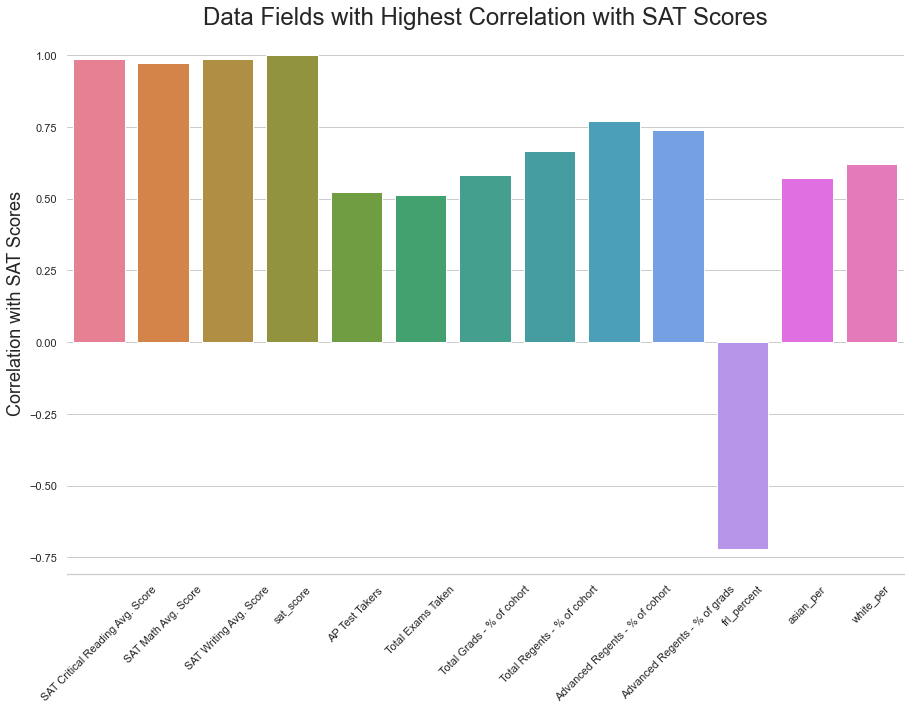

In [16]:
# Instead of individual scatter plots, we'll use a bar plot since there are so many fields
bargraph(high_corr_df, 0, 1, '', 'Correlation with SAT Scores', 'Data Fields with Highest Correlation with SAT Scores')

## Plotting the survey_fields columns correlations with SAT Scores

In [94]:
combined[survey_fields].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rr_s        363 non-null    float64
 1   rr_t        363 non-null    int64  
 2   rr_p        363 non-null    int64  
 3   N_s         363 non-null    float64
 4   N_t         363 non-null    float64
 5   N_p         363 non-null    float64
 6   saf_p_11    363 non-null    float64
 7   com_p_11    363 non-null    float64
 8   eng_p_11    363 non-null    float64
 9   aca_p_11    363 non-null    float64
 10  saf_t_11    363 non-null    float64
 11  com_t_11    363 non-null    float64
 12  eng_t_11    363 non-null    float64
 13  aca_t_11    363 non-null    float64
 14  saf_s_11    363 non-null    float64
 15  com_s_11    363 non-null    float64
 16  eng_s_11    363 non-null    float64
 17  aca_s_11    363 non-null    float64
 18  saf_tot_11  363 non-null    float64
 19  com_tot_11  363 non-null    f

In [17]:
# Calculating all 'survey_fields' correlations with 'SAT scores'
survey_corr = combined.corr()['sat_score'][survey_fields]
print(survey_corr)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


In [18]:
# Printing all columns with high correlation of more than 0.2 or less than 0.1 (based on the above list)
high_survey_corr = {}
for index, value in survey_corr.items():
    if value >= 0.2 or value <= -0.1:
        high_survey_corr[index] = value

# Turning the results into a DataFrame        
high_survey_corr
high_survey_corr_df = pd.DataFrame(high_survey_corr.items())

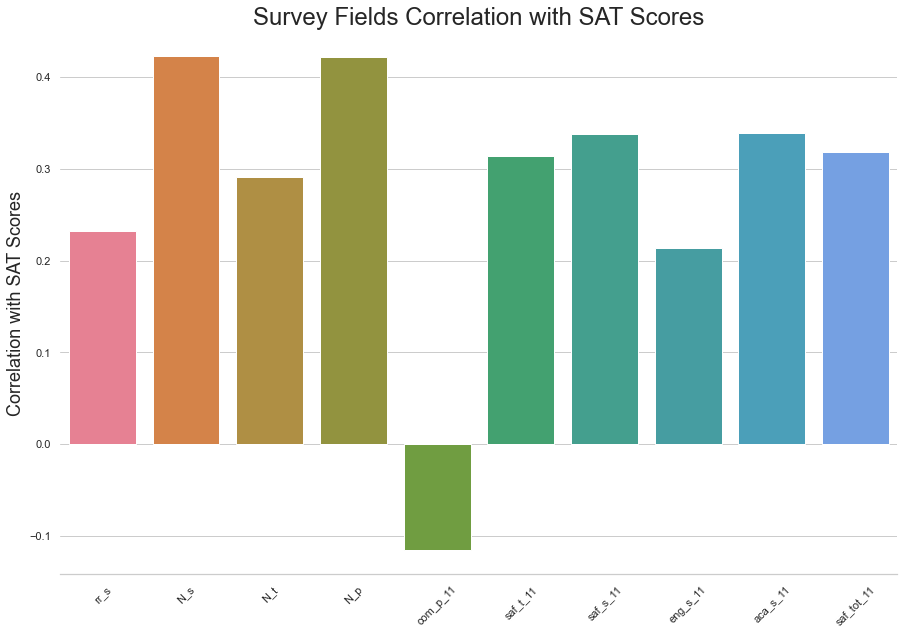

In [19]:
# Plotting the new DataFrame
bargraph(high_survey_corr_df, 0, 1, '', 'Correlation with SAT Scores', 'Survey Fields Correlation with SAT Scores')

## Analyzing survey_fields correlation with SAT score:

We will omit the N_s (number of students), N_t (number of teachers), and N_p (number of parents) from the results as these only tell us the number of responses the survey received from each category.

The strongest correlations are with the student and teacher response rates for safety as well as total safety rating (saf_s_11, saf_t_11, saf_tot_11), and the student response for academia (aca_s_11). This may mean that the safer the school feels, the easier it is for students to learn, or it might be other contributing factors that come with safer schools. However, the parent response rate seems to have a much weaker correlation, which is a bit surprising and proposes the question of whether there's a disconnect between how parents think/feel about their children's school safety versus reality.

The student responses on their school's academia have a high correlation with SAT score and that makes sense since the students who feel that the academic level of their school is high (i.e. - they are confident in their learning) are probably also doing well on the SATs. The remaining fields in the survey (communication, engagement) don't seem to have a strong correlation for either the students, teachers, or parents, but may have some slight correlation.

Another interesting point to note is that communication score of the school based on parent rating (com_p_11) has a slight negative correlation with SAT, which could indicate that lower SAT scores may have something to do with how well the school communicates with the parents. If the parents are being communicated with regularly about their child's academic performance, they are probably more likely to get more involved and possibly ensure their child's academia improves. 

## Plotting student safety score by correlation with avg SAT score

In [20]:
def scatterplot(x, y, color, xlabel, ylabel, title):
    plt.figure(figsize=(14,7))
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, y, 'o', markersize=10, color=color, alpha=0.5)
    plt.plot(x, m*x+b, color='red')
    plt.xlabel(xlabel, size=18)
    plt.ylabel(ylabel, size=18)
    plt.title(title, size=22)
    return plt.show()

In [21]:
def scattersubs(a, b, n, x, y, color, c, title, xlabel, ylabel):
    ax = plt.subplot(a,b,n)
    ax.scatter(x, y, s=15**2, color=color, alpha=0.5)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x+b, c=c)
    plt.title(title, size=20)
    plt.xlabel(xlabel, size=18)
    plt.ylabel(ylabel, size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)

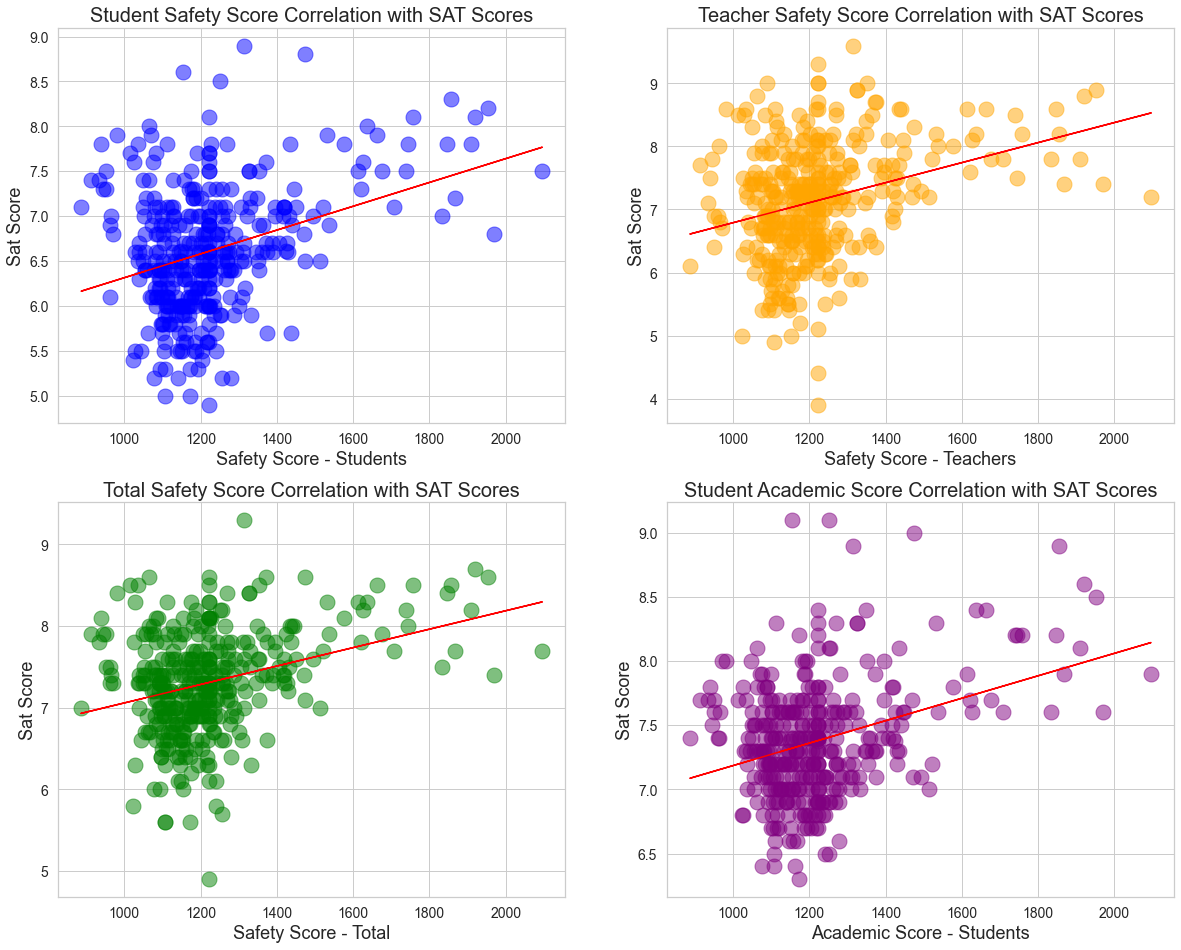

In [22]:
# Using a scatterplot to visualize the above named correlations with SAT score
plt.figure(figsize=(20,16))
scattersubs(2, 2, 1, combined['sat_score'], combined['saf_s_11'],
           'blue', 'red',
           'Student Safety Score Correlation with SAT Scores',
           'Safety Score - Students',
           'Sat Score')
scattersubs(2, 2, 2, combined['sat_score'], combined['saf_t_11'],
           'orange', 'red',
           'Teacher Safety Score Correlation with SAT Scores',
           'Safety Score - Teachers',
           'Sat Score')
scattersubs(2, 2, 3, combined['sat_score'], combined['saf_tot_11'],
           'green', 'red',
           'Total Safety Score Correlation with SAT Scores',
           'Safety Score - Total',
           'Sat Score')
scattersubs(2, 2, 4, combined['sat_score'], combined['aca_s_11'],
           'purple', 'red',
           'Student Academic Score Correlation with SAT Scores',
           'Academic Score - Students',
           'Sat Score')
plt.show()

## Analysis of correlation between safety and SAT scores:
From looking at the scatter plots above, there is a definite correlation between the students rating of school safety and their SAT scores. The higher the safety rating, the higher the SAT Scores for the most part (with some outliers). The majority of schools seem to have a low to mid-range safety score and a corresponding low to mid-range average SAT score. There are not many schools with safety scores above 8.0, and also not many schools with average SAT scores above 1600. There are about 5 schools with very high safety scores (above 8.0) that also have mid-range average SAT Scores (between 1100-1500).

In [23]:
# Looking at the schools with high student safety scores and low-mid SAT scores (below 1500)      
high_saf_low_sat = combined[(combined['sat_score'] <= 1500.0) & (combined['saf_s_11'] >= 8.0)]
print (high_saf_low_sat.shape)

(6, 164)


In [24]:
# Looking at the schools with lower than 8.0 student safety scores and high SAT scores (below 1500)      
high_sat_low_saf = combined[(combined['sat_score'] > 1500.0) & (combined['saf_s_11'] < 8.0)]
print (high_sat_low_saf.shape)

(19, 164)


In [25]:
high_saf_low_sat = high_saf_low_sat[['SCHOOL NAME','sat_score','AP Test Takers ', 
                            'frl_percent','asian_per','black_per','hispanic_per','white_per',
                            'male_per','female_per','borough','saf_s_11','com_p_11','com_t_11',
                            'com_s_11','aca_tot_11','total_enrollment']]

high_sat_low_saf = high_sat_low_saf[['SCHOOL NAME','sat_score','AP Test Takers ', 
                            'frl_percent','asian_per','black_per','hispanic_per','white_per',
                            'male_per','female_per','borough','saf_s_11','com_p_11','com_t_11',
                            'com_s_11','aca_tot_11','total_enrollment']]

In [26]:
# exploring correlations with the above DataFrames and 'sat_score' to look at biggest differences
high_saf_low_sat_corr = high_saf_low_sat.corr()['sat_score']
high_sat_low_saf_corr = high_sat_low_saf.corr()['sat_score']

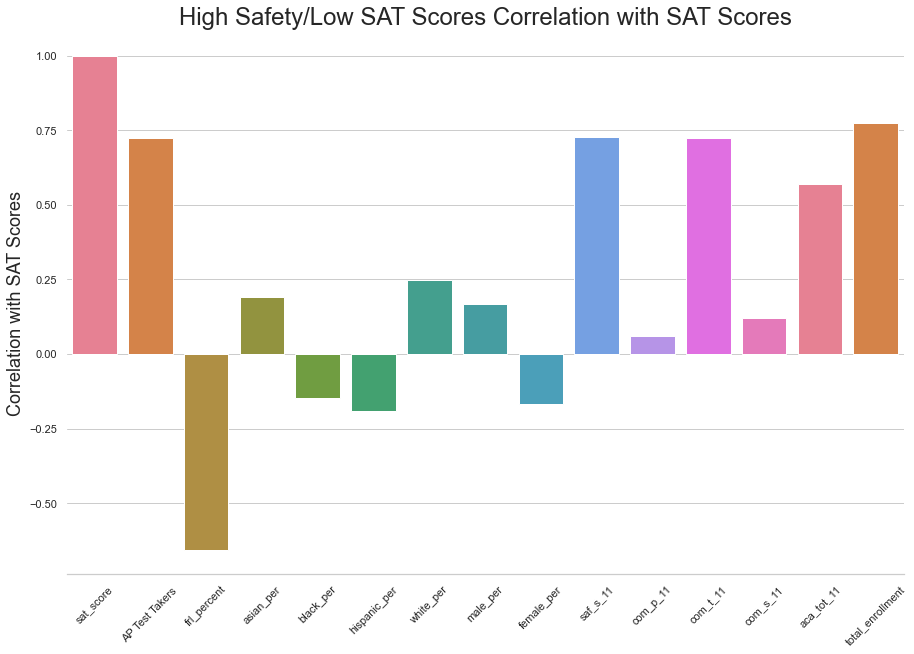

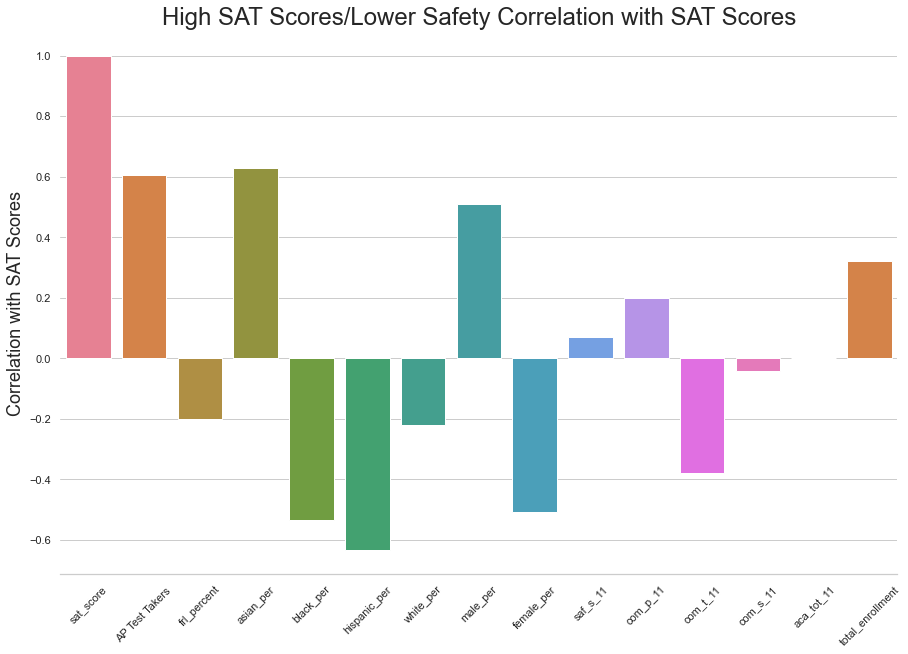

In [27]:
# Turning the results into DataFrames        
h_saf_l_sat_corr_df = pd.DataFrame(high_saf_low_sat_corr.items())
h_sat_l_saf_corr_df = pd.DataFrame(high_sat_low_saf_corr.items())

# Plotting the new DataFrame
# Instead of individual scatter plots, we'll use a bar plot since there are so many fields 

bargraph(h_saf_l_sat_corr_df, 0, 1, '', 
         'Correlation with SAT Scores', 
         'High Safety/Low SAT Scores Correlation with SAT Scores')

print ('\n')

bargraph(h_sat_l_saf_corr_df, 0, 1, '', 
         'Correlation with SAT Scores', 
         'High SAT Scores/Lower Safety Correlation with SAT Scores')

## Analyzing the above two bar graphs

We should take all of this data with a grain of salt, given that there are far fewer schools in the data for the first graph (6 schools) than the second (19 schools) and that this can skew the data.

What's interesting in the findings of these 2 graphs is that we can see a clear difference in 'frl_percent' (students enrolled in the Free and Reduced Lunch program), as well as the 'race' fields. 'frl_percent' has a high negative correlation with sat_score in the first graph (the lower SAT Score and higher safety rating graph), and only has a slight negative correlation in the second graph (higher SAT Score and slightly lower safety ratings). This seems to indicate that students who are enrolled in the FRL program tend to get lower SAT scores, and it's worth looking into to find out why. It's possible that the type of food they are eating in this program is negatively impacting the students cognition and ultimately their test scores, or that the students who qualify for these programs have other factors in their lives that are negatively impacting their performance. 


The 'asian_per' or Asian percent of student body field is much more highly correlated with the SAT Scores in the second graph than the first, and the 'black_per' and 'hispanic_per' or Black percent and Hispanic percent of student body are much more negatively correlated with the second graph than the first. This means that Asian students are more likely to have higher SAT Scores, and Black and Hispanic students are more likely to have lower SAT Scores. White students also have a fairly big difference in the first to second graph with a slightly positive correlation in the first graph and a slight negative correlation in the second graph. Again, this is worth exploring further to try to find the reasons for the big discrepancies between the students' races and SAT Scores. 

Another point that stands out is the 'male_per' and 'female_per' fields, which represent male and female student body percentages respectively. Male percentage has a slight positive correlation and female has a slight negative correlation in the first graph and both more than double in correlation in the second graph. It seems female students do more poorly in SAT Scores in this group than males and this is also worth exploring.

One more point that is worth exploring here is the 'com_t_11' field which represents the communication score based on teacher responses from the school surveys. This field has a high positive correlation in the first graph and a fairly negative correlation in the second graph. It seems that although safety and teacher communication scores are high, it doesn't necessarily mean that students SAT Scores will be high, although they may help slightly. The overall SAT Scores in the first graph are generally low or at best mid. What is interesting is that the teacher communication score in the second graph seems to say that teacher communication scores are generally lower in schools with high SAT Score Averages. 

## Exploring the high correlation data aggregated by NY borough

Brooklyn         106
Bronx             93
Manhattan         90
Queens            64
Staten Island     10
Name: borough, dtype: int64


Text(0.5, 1.0, 'Number of Schools Per Borough')

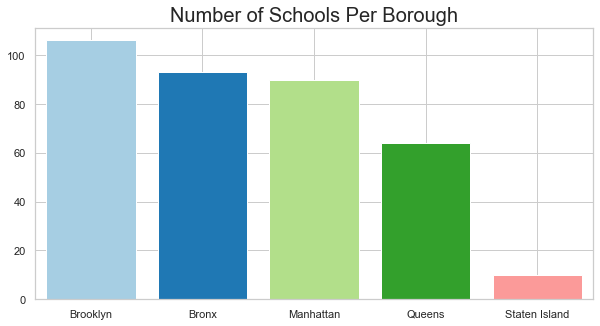

In [28]:
# Converting 'borough' dict to variable for ease and getting value counts
borough = combined['borough']
borough_counts = borough.value_counts()
print (borough_counts)

# Plotting the value counts using a bar graph

plt.figure(figsize=(10,5))
borough_counts.plot(kind='bar', rot=360)
plt.bar(range(len(borough_counts)), borough_counts, color=plt.cm.Paired(np.arange(len(borough_counts))))
plt.title('Number of Schools Per Borough', size=20)

         borough  saf_s_11
0      Manhattan  6.831370
1         Queens  6.721875
2          Bronx  6.606577
3  Staten Island  6.530000
4       Brooklyn  6.370755


Text(0.5, 1.0, 'Avg Student Safety Score Per Borough')

<Figure size 1008x504 with 0 Axes>

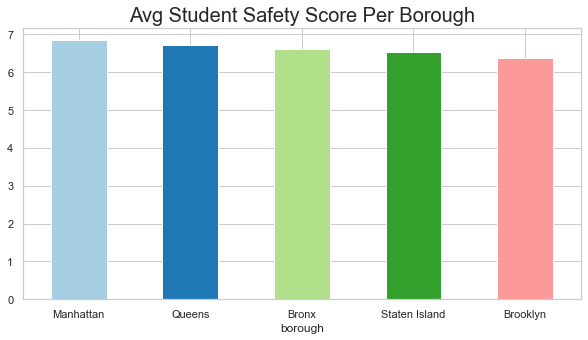

In [29]:
# Computing avg student rated safety score for each borough
avg_saf_score = combined['saf_s_11']
avg_saf_borough = avg_saf_score.groupby(borough).agg(np.mean)
avg_saf_borough = pd.DataFrame(avg_saf_borough)
avg_saf_borough = avg_saf_borough.reset_index().sort_values(by=['saf_s_11'], ascending=False).reset_index(drop=True)
print (avg_saf_borough)

# Plotting avg student rated safety score for each borough using bar graph
plt.figure(figsize=(14,7))
avg_saf_borough.plot.bar(x=0, y=1, rot=0, figsize=(10,5), legend=False, color=plt.cm.Paired(np.arange(len(avg_saf_borough))))
plt.title('Avg Student Safety Score Per Borough', size=20)

We see from the above that Manhattan has the highest student rated safety score, followed by Queens, then the Bronx, Staten Island, and in last place: Brooklyn. Brooklyn has the highest number of schools, but the lowest average safety score out of the 5 boroughs.

In [30]:
# Using geopandas to bring in a base layer of NYC boroughs
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.head(5)

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


         borough  sat_score
0  Staten Island     1382.0
1         Queens     1287.0
2      Manhattan     1278.0
3       Brooklyn     1181.0
4          Bronx     1158.0


Text(0.5, 1.0, 'Avg Student SAT Score Per Borough')

<Figure size 1008x504 with 0 Axes>

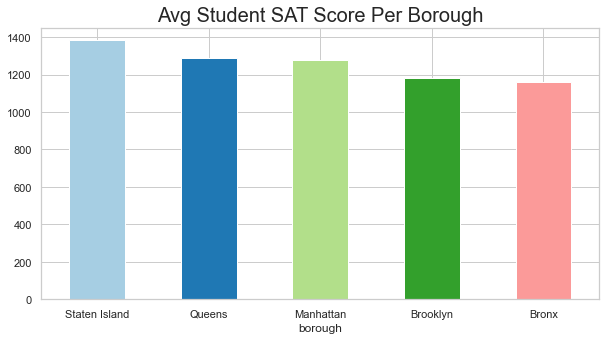

In [31]:
# Computing avg student rated safety score for each borough
avg_sat_score = combined['sat_score']
avg_sat_borough = round(avg_sat_score.groupby(borough).agg(np.mean))
avg_sat_borough = pd.DataFrame(avg_sat_borough)
avg_sat_borough = avg_sat_borough.reset_index().sort_values(by=['sat_score'], ascending=False).reset_index(drop=True)
print (avg_sat_borough)

# Plotting avg student rated safety score for each borough using bar graph
plt.figure(figsize=(14,7))
avg_sat_borough.plot.bar(x=0, y=1, rot=0, figsize=(10,5), legend=False, color=plt.cm.Paired(np.arange(len(avg_sat_borough))))
plt.title('Avg Student SAT Score Per Borough', size=20)

## Summary of Average Safety and SAT Scores by Borough:

+ Staten Island has far fewer schools than all other boroughs, with only 10 schools.
+ Staten Island also has the highest avg. SAT score but given it has only 10 schools, it's not really a fair comparison - but it is worth noting.
+ Manhatten has the highest safety rating by students, but not the highest SAT scores.
+ Brooklyn has the lowest safety rating by students but is surprisingly not the lowest in avg. SAT score.
+ The Bronx has the lowest avg. SAT score, although it is 3rd in safety ratings by students.
+ There doesn't seem to be any direct relationship between student safety ratings of schools and avg. SAT score by borough.

In [32]:
#Making a list of longitutes and latitudes of each school district
districts = combined.groupby('school_dist').mean()
districts.reset_index(inplace=True)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

school_locs = pd.DataFrame()
school_locs['lon'] = longitudes
school_locs['lat'] = latitudes

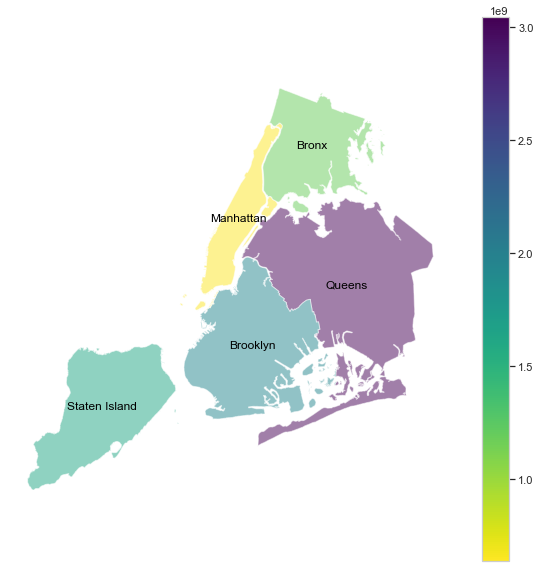

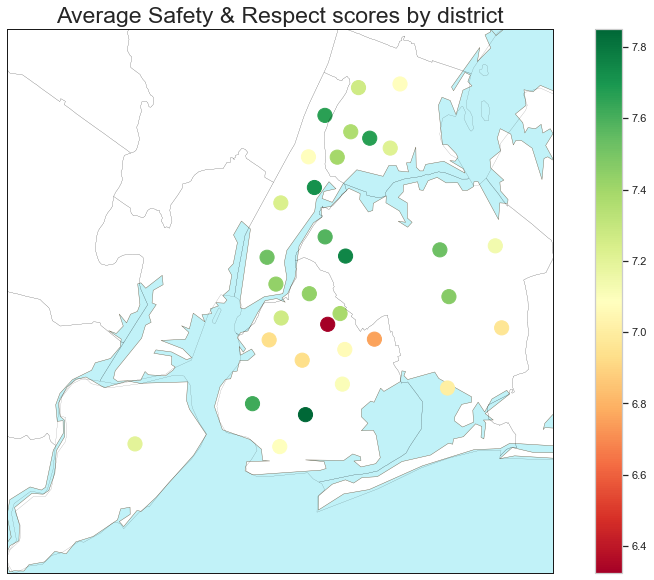

In [33]:
# Plotting NYC Boroughs
fig,ax = plt.subplots(1,1, figsize=(10,10))
base = nyc.plot(column='Shape_Area', cmap='viridis_r', alpha=.5, ax=ax, legend=True)
nyc.apply(lambda x: ax.annotate(text=x.BoroName, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.axis('off')
plt.show()

# Creating a base map
plt.figure(figsize=(15, 10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)
m.drawmapboundary(fill_color='#c1f2f8')
m.drawcoastlines(color='#6D5F47', linewidth=0.4)
m.drawrivers(color='#6D5F47', linewidth=0.4)
m.fillcontinents(color='white')
m.drawcounties(color='black',zorder=999)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()


# Plotting average safety & respect scores by school districts
m.scatter(
    longitudes, 
    latitudes, 
    s=200, 
    zorder=2, 
    latlon=True, 
    c=districts['saf_tot_11'],
    cmap='RdYlGn'               # A traffic-light template, with green - the safest, 
)                               # red - the least safe

plt.colorbar()
plt.title('Average Safety & Respect scores by district', fontsize=23)
plt.show()

We can see from the above map that Brooklyn has a few of the least safe school districts but not all school districts in Brooklyn are rated as unsafe. Interestingly, the least safe school district is very close to a school district with a relatively high safety rating.

In [34]:
saf_boro = combined[['borough', 'school_dist', 'SCHOOL NAME', 'sat_score', 'saf_s_11']]
saf_low_brooklyn = saf_boro[(saf_boro['borough'] == 'Brooklyn') & (saf_boro['saf_s_11'] < 5.8)]
saf_high_brooklyn = saf_boro[(saf_boro['borough'] == 'Brooklyn') & (saf_boro['saf_s_11'] > 7.4)]
print (saf_low_brooklyn)
print ('\n')
print (saf_high_brooklyn)

      borough school_dist                                        SCHOOL NAME  \
193  Brooklyn          13  GEORGE WESTINGHOUSE CAREER AND TECHNICAL EDUCA...   
201  Brooklyn          14                           SCHOOL FOR LEGAL STUDIES   
207  Brooklyn          14                             AUTOMOTIVE HIGH SCHOOL   
212  Brooklyn          15                           SECONDARY SCHOOL FOR LAW   
216  Brooklyn          15             COBBLE HILL SCHOOL OF AMERICAN STUDIES   
222  Brooklyn          16             THE BROOKLYN ACADEMY OF GLOBAL FINANCE   
223  Brooklyn          17  ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...   
224  Brooklyn          17                 ACADEMY OF HOSPITALITY AND TOURISM   
228  Brooklyn          17                SCHOOL FOR DEMOCRACY AND LEADERSHIP   
229  Brooklyn          17  HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...   
230  Brooklyn          17      HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS   
233  Brooklyn          17    BROOKLYN AC

We can see above that there are some districts that have both the least and most safe schools according to student safety ratings (districts 13 and 14), which could mean that safety can come down to certain neighborhoods within districts, or it could mean that some schools have more safety measures in place to make students feel safer.

## Exploring 'frl_percent' further

In [35]:
# Calculating all correlations with FRL Percent
frl_correlations = combined.corr()["frl_percent"]

In [36]:
# Printing all columns with high correlation of more than 0.2 or less than 0.1 (based on the above list)
high_frl_corr = {}
for index, value in frl_correlations.items():
    if value >= 0.4 or value <= -0.4:
        high_frl_corr[index] = value

# Turning the results into a DataFrame        
high_frl_corr
high_frl_corr = pd.DataFrame(high_frl_corr.items())
print (high_frl_corr)

                                  0         1
0   SAT Critical Reading Avg. Score -0.728239
1               SAT Math Avg. Score -0.676980
2            SAT Writing Avg. Score -0.726211
3                         sat_score -0.722225
4         Total Grads - % of cohort -0.470011
5       Total Regents - % of cohort -0.523438
6    Advanced Regents - % of cohort -0.532949
7     Advanced Regents - % of grads -0.514274
8                AVERAGE CLASS SIZE -0.400651
9                       frl_percent  1.000000
10                      ell_percent  0.432673
11                     hispanic_per  0.571657
12                        white_num -0.522679
13                        white_per -0.722343


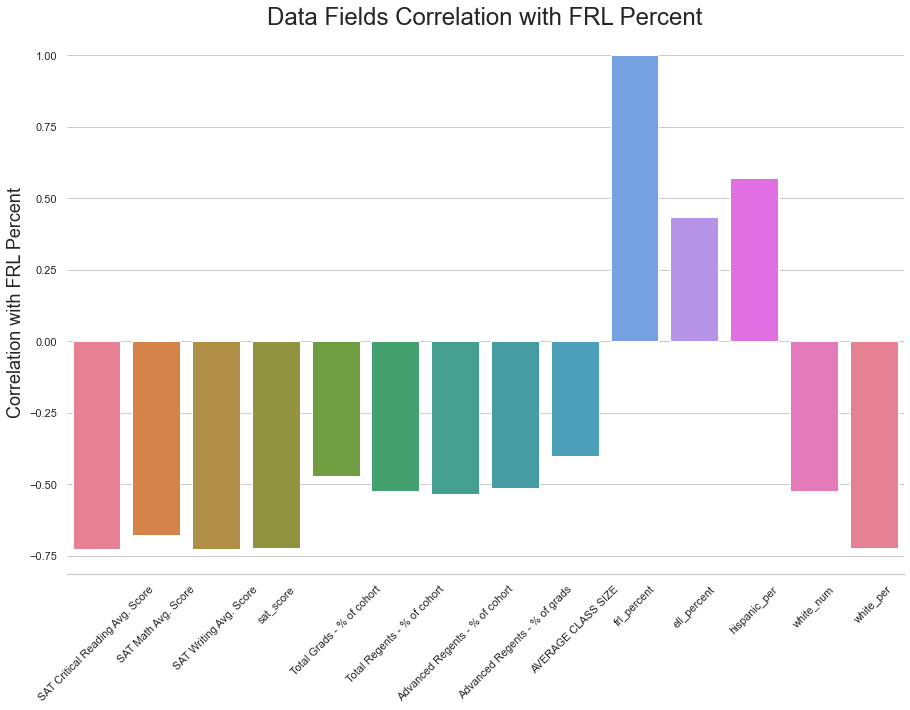

In [37]:
# Plotting the new DataFrame
bargraph(high_frl_corr, 0, 1, '', 
         'Correlation with FRL Percent', 
         'Data Fields Correlation with FRL Percent')

## Analyzing the above graph

We can see a clear negative correlation between FRL program enrollment and SAT Scores. We can also see that the majority of enrollees in the FRL program are Hispanic, and that the majority of White students are not enrolled in the program. This indicates that the majority of Hispanic students belong to lower income families, and the majority of white students do not. We can also see that there is a correlation between the FRL program and ELL enrolled students (English Language Learners), which could be a big factor in the lower SAT scores.

## Converting racial percentages to variables for ease and creating race DataFrame

In [38]:
#converting avg racial percentages into variables
white = combined['white_per'].agg(np.mean)
asian = combined['asian_per'].agg(np.mean)
black = combined['black_per'].agg(np.mean)
hispanic = combined['hispanic_per'].agg(np.mean)

races = ['white','asian','black','hispanic']
races_avg_per = [white,asian,black,hispanic]
    
races_combined = pd.DataFrame(races_avg_per, races)
races_combined

,0
white,8.430028
asian,10.149587
black,36.575207
hispanic,44.068320


In [39]:
white_sat_corr = combined.corr()['sat_score']['white_per']
asian_sat_corr = combined.corr()['sat_score']['asian_per']
black_sat_corr = combined.corr()['sat_score']['black_per']
hispanic_sat_corr = combined.corr()['sat_score']['hispanic_per']

races = ['white','asian','black','hispanic']
races_corr = [white_sat_corr, asian_sat_corr, black_sat_corr, hispanic_sat_corr]
    
races_combined_corr = pd.DataFrame(races_corr, races)
races_combined_corr

,0
white,0.620718
asian,0.570730
black,-0.284139
hispanic,-0.396985


## Plotting racial difference in SAT scores

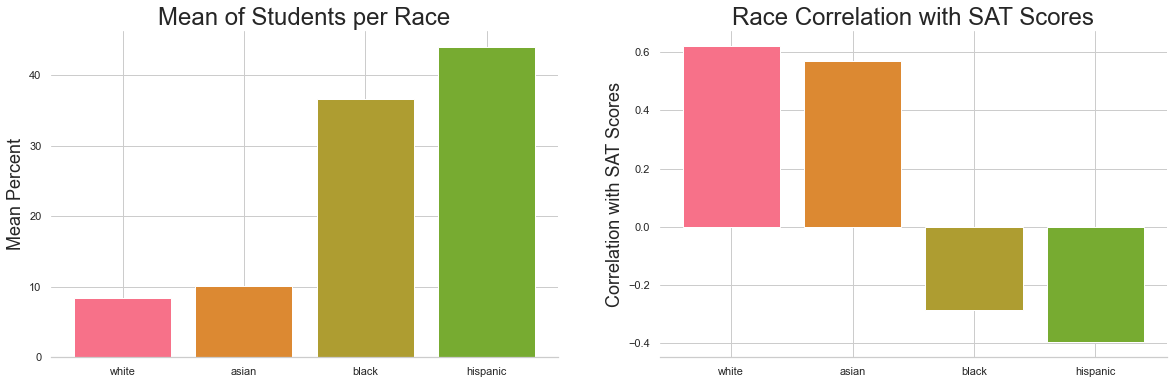

In [40]:
# Creating bar plots for race and SAT score correlation
plt.figure(figsize=(20,6))
ax1 = plt.subplot(1,2,1)
sns.set(style="whitegrid")
ax1.bar(races_combined.index, races_combined[0], color=sns.color_palette("husl", 10))
plt.xlabel('')
plt.ylabel('Mean Percent', fontsize=18)
plt.title('Mean of Students per Race', fontsize=24)
sns.despine(left=True)

ax2 = plt.subplot(1,2,2)
sns.set(style="whitegrid")
ax2.bar(races_combined_corr.index, races_combined_corr[0], color=sns.color_palette("husl", 10))
plt.xlabel('')
plt.ylabel('Correlation with SAT Scores', fontsize=18)
plt.title('Race Correlation with SAT Scores', fontsize=24)
sns.despine(left=True)

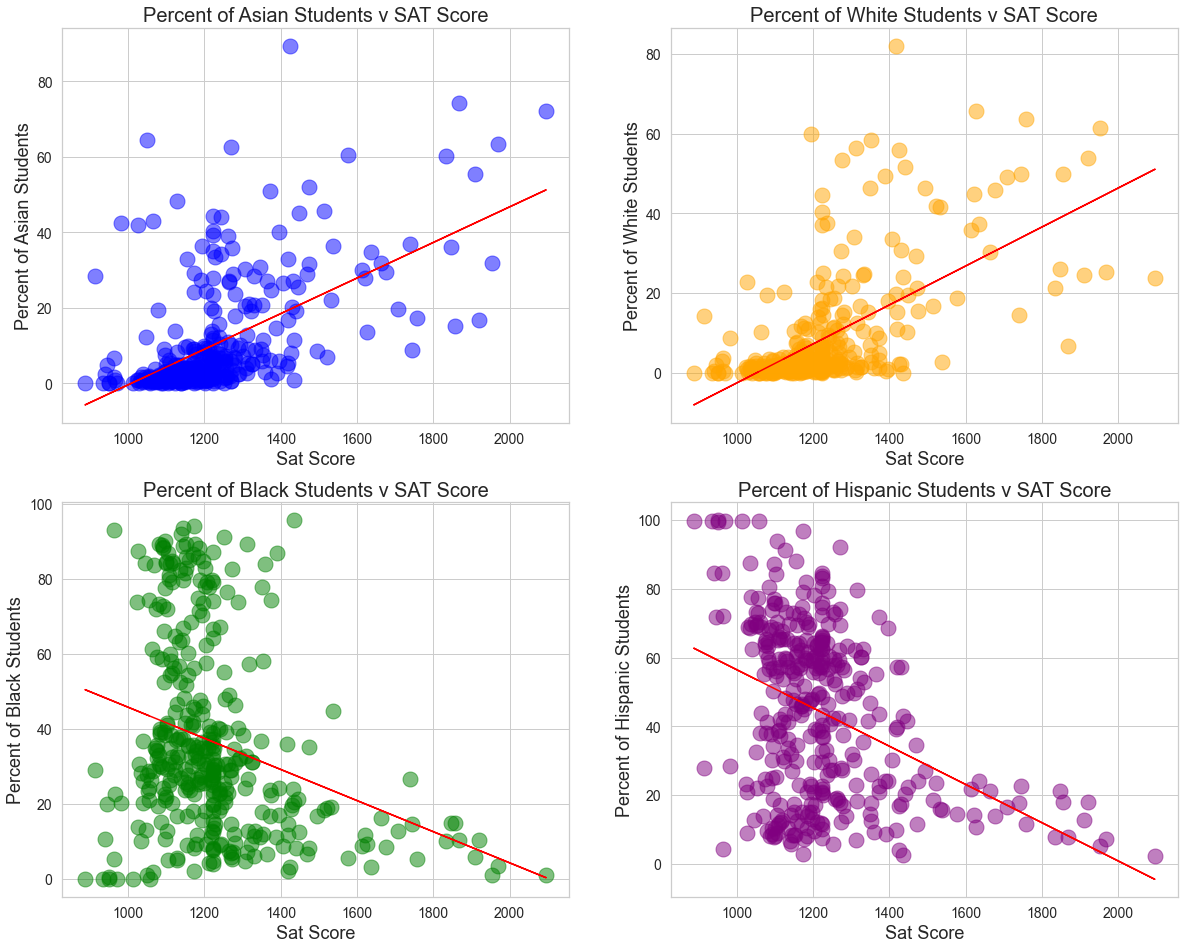

In [41]:
# Plotting race vs. SAT scores
plt.figure(figsize=(20,16))

scattersubs(2, 2, 1, combined['sat_score'], combined['asian_per'],
           'blue', 'red',
           'Percent of Asian Students v SAT Score',
           'Sat Score',
           'Percent of Asian Students')
scattersubs(2, 2, 2, combined['sat_score'], combined['white_per'],
           'orange', 'red',
           'Percent of White Students v SAT Score',
           'Sat Score',
           'Percent of White Students')
scattersubs(2, 2, 3, combined['sat_score'], combined['black_per'],
           'green', 'red',
           'Percent of Black Students v SAT Score',
           'Sat Score',
           'Percent of Black Students')
scattersubs(2, 2, 4, combined['sat_score'], combined['hispanic_per'],
           'purple', 'red',
           'Percent of Hispanic Students v SAT Score',
           'Sat Score',
           'Percent of Hispanic Students')
plt.show()

## Analzying the race and SAT score correlation:

+ From the bar graphs above, it seems that there are overall more black and hispanic students than white or asian students in NY high schools in general, but different schools have different distributions of race. 
+ From the graphs we can see that schools with lower percentages of black and hispanic students on average do better on the SATs, than schools with higher percents of black and hispanic students. 
+ The opposite seems to be true of white and asian students, where the higher the percent of them at a school, the higher the SAT scores are on average. This does not tell us that certain races are smarter than others, but it does tell us there is a correlation between race and SAT scores that need to be explored further to understand why there is a racial gap in SAT scores. 

Contributing factors may be such things as school safety, socio-economic status, parents education as well as their engagement in students academic life, communication between schools and parents, do they live in a single parent or multi-parent home, what the students home-life and extra-curricular life is like, school resources and budget, student attendance, as well as many other factors.

Another thing to look into would be the outlier schools with high percentages of black or hispanic students and high SAT scores, to see what sets them apart from the other schools.

## Exploring schools with high hispanic rates and low SAT scores

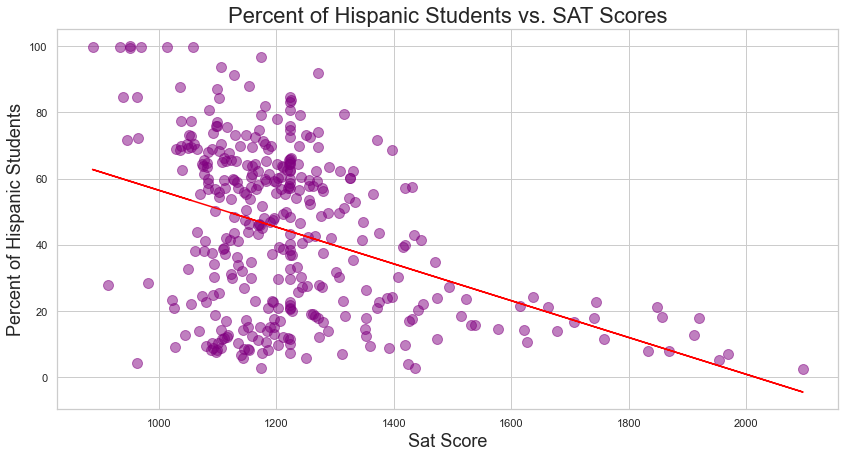

In [42]:
scatterplot(combined['sat_score'], combined['hispanic_per'], 'purple', 
            'Sat Score', 'Percent of Hispanic Students', 
            'Percent of Hispanic Students vs. SAT Scores')

## Analyzing the Hispanic student percent correlation with SAT score:
The scatter plot shows there is a fairly high negative correlation between the percent of hispanic students in NY high schools and SAT scores. The schools with below 25% hispanic students on average do much better on the SAT than the schools with above 25% hispanic student body. The majority of NY schools have higher than 25% hispanic student body, with the majority averaging less 1500 SAT score. The high schools with the highest rates of hispanic students (80% or higher) skew towards even lower SAT scores with under 1400. If we consider that ESL students also do not do well on the SAT, my prediction is we may see a lot of overlap with the hispanic student population and the ESL student SAT scores.

In [43]:
hisp_schools = combined[combined['hispanic_per'] > 95]

In [44]:
# separating just the columns we want to compare
hisp_schools.loc[:,'ap_test_takers_per'] = round(hisp_schools.loc[:,'AP Test Takers ']/hisp_schools.loc[:,'total_enrollment'],2)*100
hisp_schools.loc[:,'average_class_size'] = round(hisp_schools.loc[:,'AVERAGE CLASS SIZE'],2)
hisp_schools_frl_ell = hisp_schools.loc[:,('SCHOOL NAME', 'sat_score', 'frl_percent', 'ell_percent', 'male_per', 'female_per', 'ap_test_takers_per', 'total_enrollment', 'average_class_size')]
hisp_schools_frl_ell = hisp_schools_frl_ell.set_index('SCHOOL NAME')
hisp_schools_frl_ell

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,sat_score,frl_percent,ell_percent,male_per,female_per,ap_test_takers_per,total_enrollment,average_class_size
SCHOOL NAME,,,,,,,,
MANHATTAN BRIDGES HIGH SCHOOL,1058.0,83.5,72.6,51.4,48.6,12.0,541,23.48
WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,87.5,19.6,55.8,44.2,21.0,602,28.06
GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS,1014.0,92.8,89.6,48.9,51.1,19.0,472,25.43
ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,85.7,86.6,48.8,51.2,6.0,336,23.71
INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,78.3,79.9,49.0,51.0,9.0,606,23.72
PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,100.0,92.9,51.5,48.5,32.0,406,15.36
MULTICULTURAL HIGH SCHOOL,887.0,73.4,94.6,49.8,50.2,11.0,406,23.81
PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,78.3,91.3,47.8,52.2,35.0,366,19.73


In [45]:
# Creating a correlation DataFrame using 'sat_score' correlation with the above columns
hisp_schools_frl_ell_corr = hisp_schools_frl_ell.corr()['sat_score']
hisp_schools_frl_ell_corr

sat_score             1.000000
frl_percent           0.379607
ell_percent          -0.885803
male_per              0.820237
female_per           -0.820237
ap_test_takers_per    0.136142
total_enrollment      0.586013
average_class_size    0.480409
Name: sat_score, dtype: float64

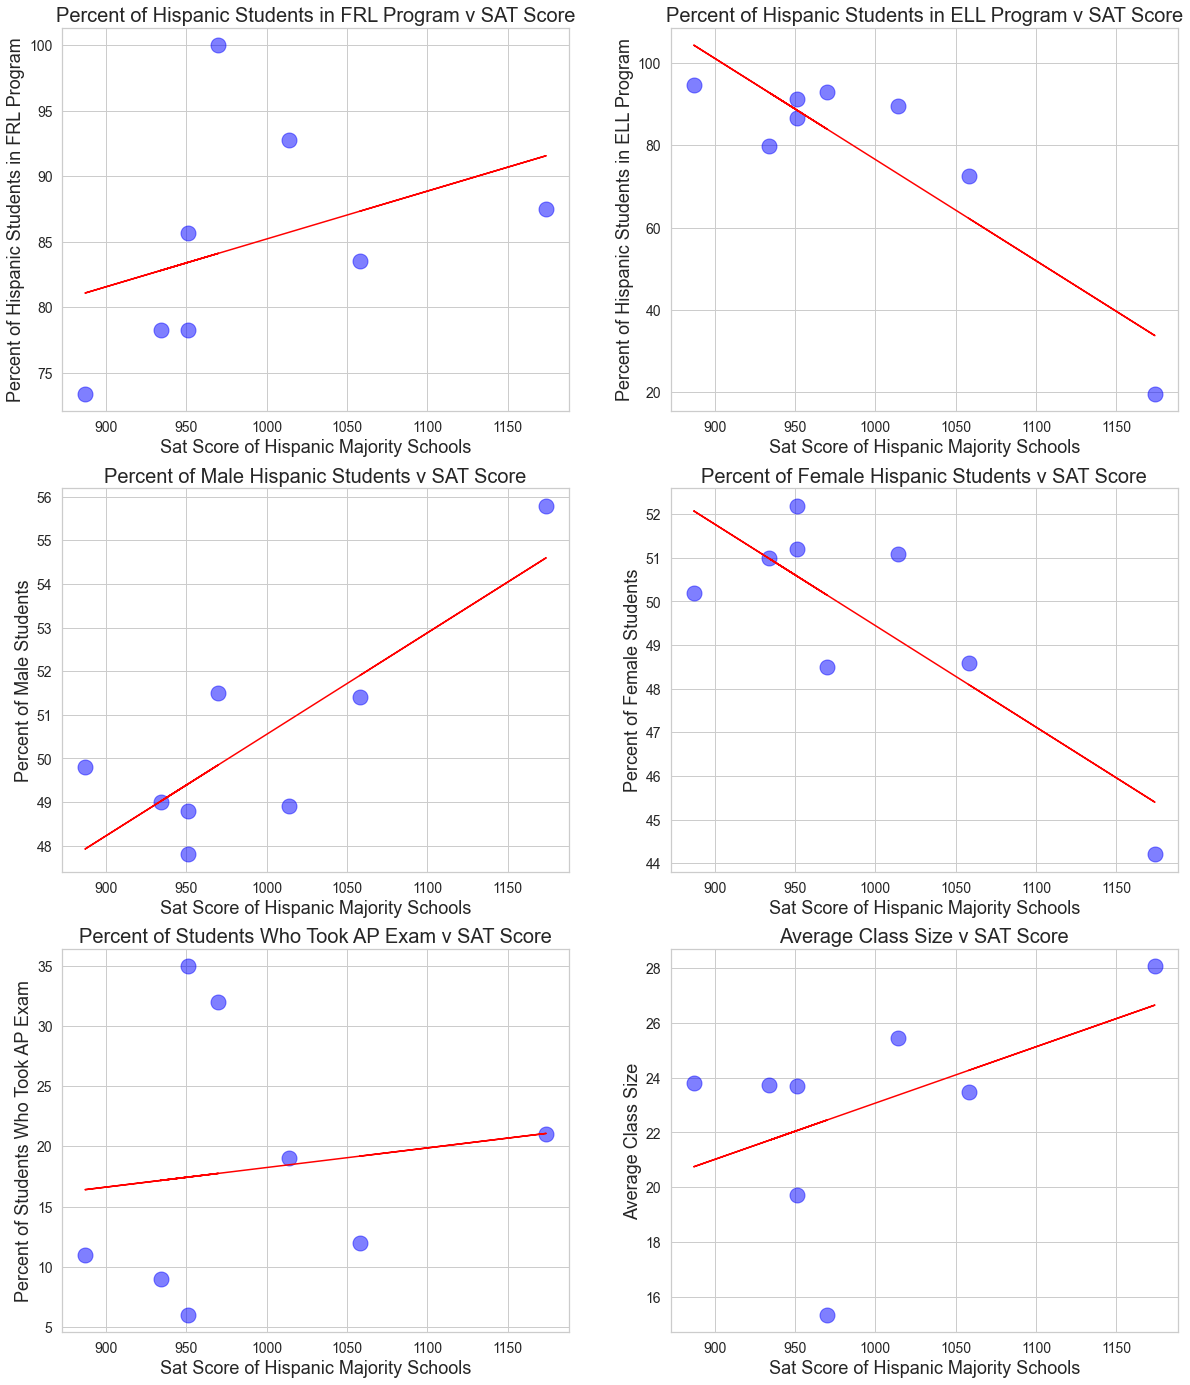

In [46]:
# Plotting the correlations using scatter plots
plt.figure(figsize=(20,24))

scattersubs(3, 2, 1, hisp_schools_frl_ell['sat_score'], hisp_schools_frl_ell['frl_percent'],
           'blue', 'red', 'Percent of Hispanic Students in FRL Program v SAT Score',
           'Sat Score of Hispanic Majority Schools', 
           'Percent of Hispanic Students in FRL Program')
scattersubs(3, 2, 2, hisp_schools_frl_ell['sat_score'], hisp_schools_frl_ell['ell_percent'],
           'blue', 'red', 'Percent of Hispanic Students in ELL Program v SAT Score',
           'Sat Score of Hispanic Majority Schools', 
           'Percent of Hispanic Students in ELL Program')
scattersubs(3, 2, 3, hisp_schools_frl_ell['sat_score'], hisp_schools_frl_ell['male_per'],
           'blue', 'red', 'Percent of Male Hispanic Students v SAT Score',
           'Sat Score of Hispanic Majority Schools', 
           'Percent of Male Students')
scattersubs(3, 2, 4, hisp_schools_frl_ell['sat_score'], hisp_schools_frl_ell['female_per'],
           'blue', 'red', 'Percent of Female Hispanic Students v SAT Score',
           'Sat Score of Hispanic Majority Schools', 
           'Percent of Female Students')
scattersubs(3, 2, 5, hisp_schools_frl_ell['sat_score'], hisp_schools_frl_ell['ap_test_takers_per'],
           'blue', 'red', 'Percent of Students Who Took AP Exam v SAT Score',
           'Sat Score of Hispanic Majority Schools', 
           'Percent of Students Who Took AP Exam')
scattersubs(3, 2, 6, hisp_schools_frl_ell['sat_score'], hisp_schools_frl_ell['average_class_size'],
           'blue', 'red', 'Average Class Size v SAT Score',
           'Sat Score of Hispanic Majority Schools', 
           'Average Class Size')
plt.show()

## Summary of the high schools with 95%+ hispanic enrollment:

+ The main point that stands out to me is that the high rate of ELL students at these schools has a high negative correlation with SAT Scores. 
 + It's possible that if the exams were given in the students first language, that we could see much higher scores.
+ Female Hispanic students have a high negative correlation and male Hispanic students have a high positive correlation with SAT scores, although the actual percents are not much different.
+ FRL is a bit too all over the place to really see a pattern, but has a slightly positive correlation with SAT scores.
+ I think it's important to note that even where we see a relatively high enrollment in AP participation, we still see low SAT scores for these schools with high ELL and economic disadvantage. There doesn't seem to be much correlation between AP Test Taking and SAT Scores.
+ Interestingly, the larger the class size, the higher the SAT Scores average seems to be (although not much higher).


## Exploring schools with < 10% Hispanic student body & >1800 SAT Score Avg:

In [47]:
non_hisp_schools = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

In [48]:
# separating just the important columns
non_hisp_schools.loc[:,'AP_test_takers_per'] = round((non_hisp_schools.loc[:,'AP Test Takers '])/(non_hisp_schools.loc[:,'total_enrollment']),2)*100
non_hisp_schools.loc[:,'average_class_size'] = round(non_hisp_schools.loc[:,'AVERAGE CLASS SIZE'],2)
non_hisp_schools_frl_ell = non_hisp_schools.loc[:, ('SCHOOL NAME', 'sat_score', 'frl_percent', 'ell_percent', 'male_per', 'female_per', 'AP_test_takers_per', 'total_enrollment', 'average_class_size')]
non_hisp_schools_frl_ell = non_hisp_schools_frl_ell.set_index('SCHOOL NAME')
non_hisp_schools_frl_ell

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,sat_score,frl_percent,ell_percent,male_per,female_per,AP_test_takers_per,total_enrollment,average_class_size
SCHOOL NAME,,,,,,,,
STUYVESANT HIGH SCHOOL,2096.0,30.3,0.0,59.3,40.7,46.0,3297,31.12
BRONX HIGH SCHOOL OF SCIENCE,1969.0,34.2,0.1,57.8,42.2,39.0,3013,31.16
BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,50.7,0.1,58.3,41.7,40.0,5332,32.45
QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE,1868.0,25.6,0.2,56.5,43.5,51.0,418,26.01
STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,17.0,0.1,57.0,43.0,48.0,1104,29.59


In [49]:
# separating just the 'SCHOOL NAME', 'sat_score', and all race percent columns
non_hisp_schools_race = non_hisp_schools[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per']]
non_hisp_schools_race = non_hisp_schools_race.set_index('SCHOOL NAME')
non_hisp_schools_race

,sat_score,asian_per,white_per,black_per,hispanic_per
SCHOOL NAME,,,,,
STUYVESANT HIGH SCHOOL,2096.0,72.1,23.7,1.2,2.4
BRONX HIGH SCHOOL OF SCIENCE,1969.0,63.5,25.4,3.5,7.2
BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,60.3,21.3,10.2,7.9
QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE,1868.0,74.4,6.7,10.5,7.9
STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,31.8,61.3,1.1,5.3


In [50]:
# Creating a correlation DataFrame using 'sat_score' correlation with the above listed columns
non_hisp_schools_frl_ell_corr = non_hisp_schools_frl_ell.corr()['sat_score']
non_hisp_schools_frl_ell_corr

sat_score             1.000000
frl_percent          -0.377535
ell_percent          -0.787549
male_per              0.587097
female_per           -0.587097
AP_test_takers_per    0.060409
total_enrollment     -0.043453
average_class_size    0.223166
Name: sat_score, dtype: float64

In [51]:
# Creating a correlation DataFrame using 'sat_score' correlation with the race columns
non_hisp_schools_race_corr = non_hisp_schools_race.corr()['sat_score']
non_hisp_schools_race_corr

sat_score       1.000000
asian_per       0.078240
white_per       0.234966
black_per      -0.853081
hispanic_per   -0.914848
Name: sat_score, dtype: float64

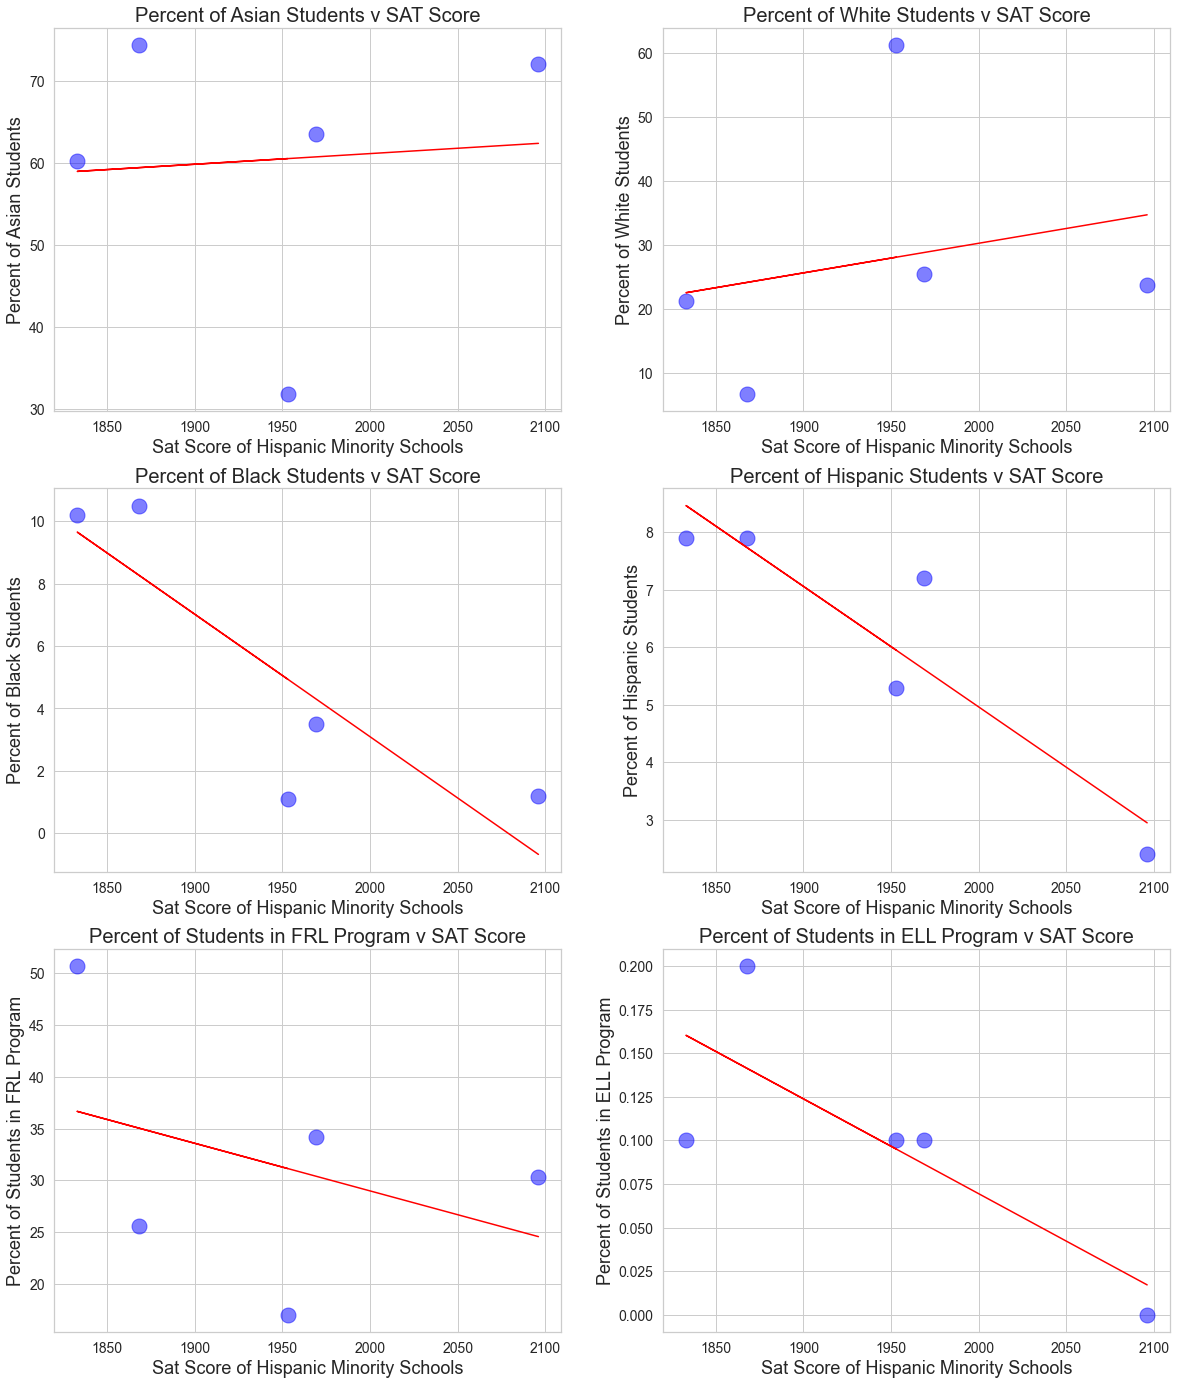

In [52]:
# Plotting the correlations using scatter plots
plt.figure(figsize=(20,24))

scattersubs(3, 2, 1, non_hisp_schools_race['sat_score'], non_hisp_schools_race['asian_per'],
           'blue', 'red', 'Percent of Asian Students v SAT Score',
           'Sat Score of Hispanic Minority Schools', 
           'Percent of Asian Students')
scattersubs(3, 2, 2, non_hisp_schools_race['sat_score'], non_hisp_schools_race['white_per'],
           'blue', 'red', 'Percent of White Students v SAT Score',
           'Sat Score of Hispanic Minority Schools', 
           'Percent of White Students')
scattersubs(3, 2, 3, non_hisp_schools_race['sat_score'], non_hisp_schools_race['black_per'],
           'blue', 'red', 'Percent of Black Students v SAT Score',
           'Sat Score of Hispanic Minority Schools', 
           'Percent of Black Students')
scattersubs(3, 2, 4, non_hisp_schools_race['sat_score'], non_hisp_schools_race['hispanic_per'],
           'blue', 'red', 'Percent of Hispanic Students v SAT Score',
           'Sat Score of Hispanic Minority Schools', 
           'Percent of Hispanic Students')
scattersubs(3, 2, 5, non_hisp_schools_frl_ell['sat_score'], non_hisp_schools_frl_ell['frl_percent'],
           'blue', 'red', 'Percent of Students in FRL Program v SAT Score',
           'Sat Score of Hispanic Minority Schools', 
           'Percent of Students in FRL Program')
scattersubs(3, 2, 6, non_hisp_schools_frl_ell['sat_score'], non_hisp_schools_frl_ell['ell_percent'],
           'blue', 'red', 'Percent of Students in ELL Program v SAT Score',
           'Sat Score of Hispanic Minority Schools', 
           'Percent of Students in ELL Program')
plt.show()

## Summary of the high schools with < 10% hispanic enrollment & > 1800 SAT score:


+ There is a disparage between rates of FRL enrolled students between these schools and the majority hispanic schools.
+ Huge disparage in ELL percent between these schools and the majority hispanic schools.
+ Also there's a slight negative correlation between ELL percent at these schools and SAT scores.
+ Race percentages seem to matter greatly to the data. 

## Plotting correlations between gender and SAT Score

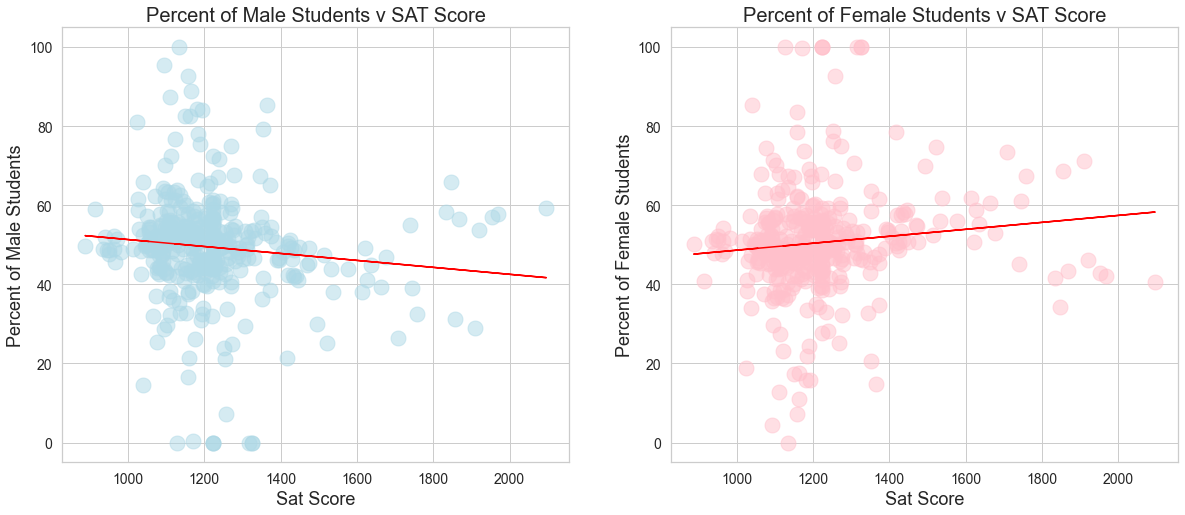

In [53]:
plt.figure(figsize=(20,8))
scattersubs(1, 2, 1, combined['sat_score'], combined['male_per'],
           'lightblue', 'red', 'Percent of Male Students v SAT Score',
           'Sat Score', 
           'Percent of Male Students')
scattersubs(1, 2, 2, combined['sat_score'], combined['female_per'],
           'pink', 'red', 'Percent of Female Students v SAT Score',
           'Sat Score', 
           'Percent of Female Students')
plt.show()

## Analyzing the correlation between gender and SAT score
From the correlation scatter plots we can see there is a very slight negative correlation between male student percentage and SAT score and a slightly positive one for female percentage and SAT score. This doesn't surprise me but it will be interesting to look into why there's an opposite correlation between the genders.

## Exploring female_per v. SAT score
What I find interesting in the above scatter plot is that the 5 schools that are 100% female do average or poorly on the SAT, as well as all the schools with below about 30% female student body. The schools with the highest SAT scores are ones with between 40-75% female student body (with the exception of one at about 30-35%). The majority of the schools that do poorly or average on the SAT fall somewhere between 35-60% female student body (this is also true for males).

In [54]:
high_fem_schools = combined[(combined['female_per'] > 55) & (combined['sat_score'] > 1700)]

In [55]:
# separating just the 'SCHOOL NAME', 'sat_score', frl_percent' and 'ell_percent' columns
high_fem_schools_data = high_fem_schools.loc[:, ('SCHOOL NAME', 'sat_score', 'frl_percent', 'ell_percent', 'asian_per', 'white_per', 'black_per', 'hispanic_per')]
high_fem_schools_data = high_fem_schools_data.set_index('SCHOOL NAME')
high_fem_schools_data

,sat_score,frl_percent,ell_percent,asian_per,white_per,black_per,hispanic_per
SCHOOL NAME,,,,,,,
BARD HIGH SCHOOL EARLY COLLEGE,1856.0,18.0,0.2,15.1,49.8,15.1,18.2
ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,15.8,0.2,17.2,63.7,5.5,11.6
BEACON HIGH SCHOOL,1744.0,18.4,0.2,8.9,49.8,14.6,22.8
FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS,1707.0,21.7,0.2,19.6,49.2,12.9,16.6
TOWNSEND HARRIS HIGH SCHOOL,1910.0,29.2,0.0,55.5,24.6,5.9,12.9


In [56]:
# Creating a correlation DataFrame using 'sat_score' correlation with the above columns
high_fem_schools_data_corr = high_fem_schools_data.corr()['sat_score']
high_fem_schools_data_corr

sat_score       1.000000
frl_percent     0.576886
ell_percent    -0.759477
asian_per       0.718326
white_per      -0.701477
black_per      -0.302115
hispanic_per   -0.304095
Name: sat_score, dtype: float64

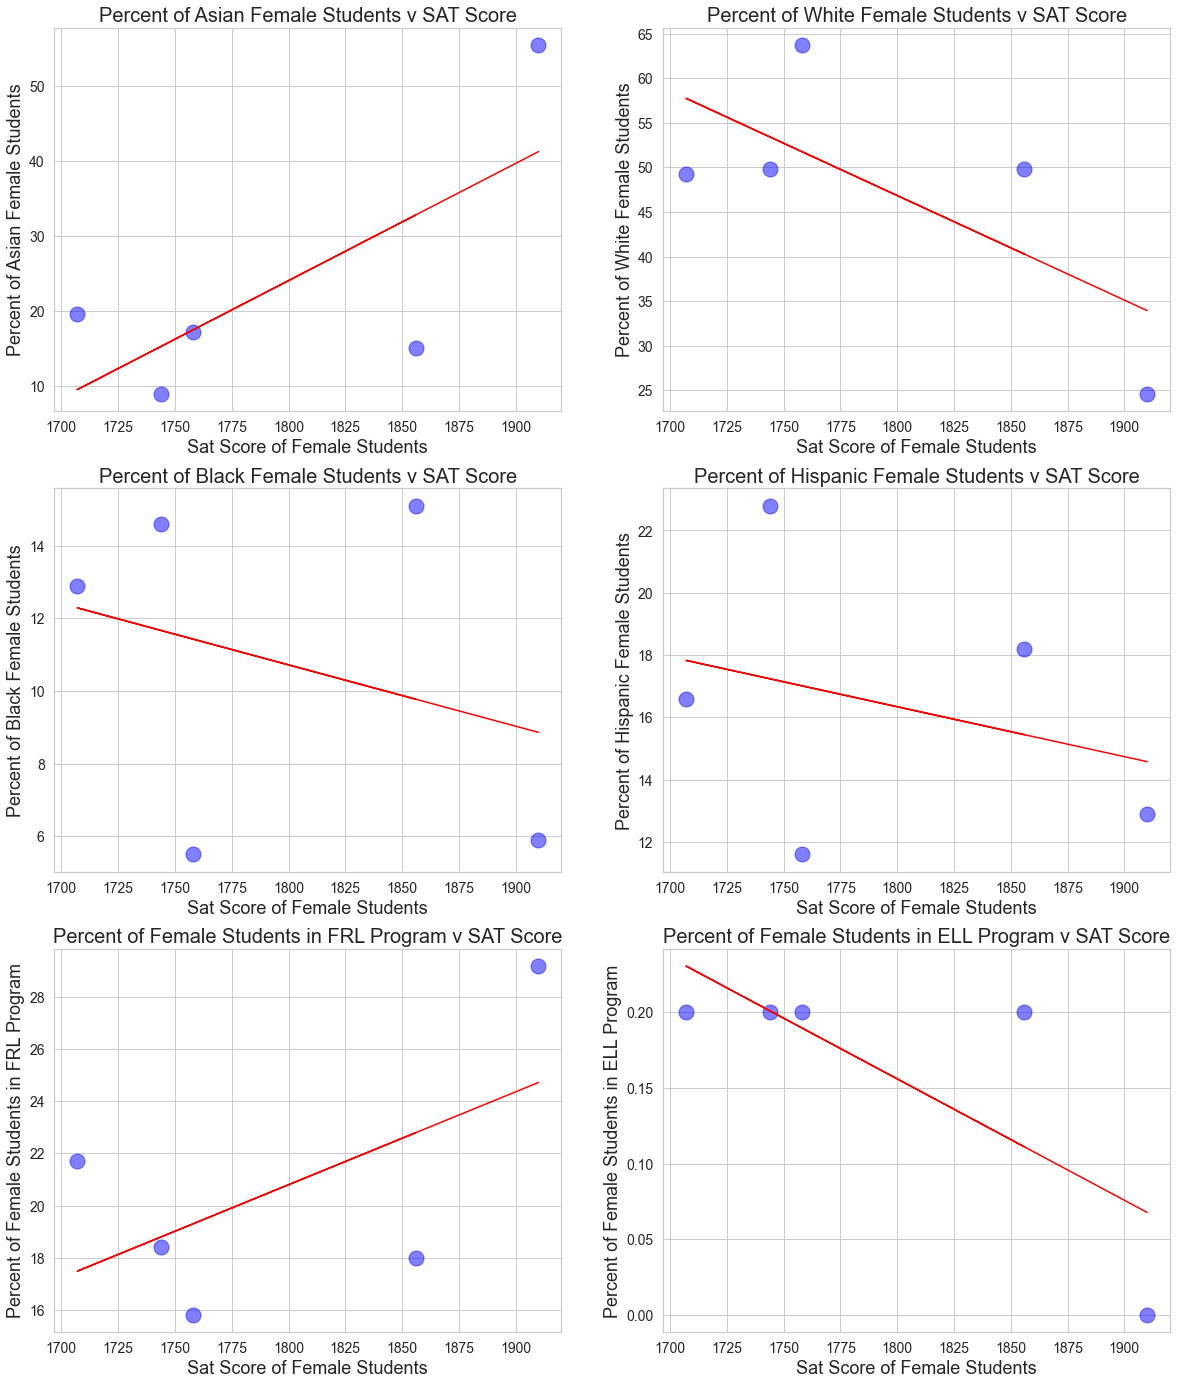

In [57]:
# Plotting the correlations using scatter plots
plt.figure(figsize=(20,24))

scattersubs(3, 2, 1, high_fem_schools_data['sat_score'], high_fem_schools_data['asian_per'],
           'blue', 'red', 'Percent of Asian Female Students v SAT Score',
           'Sat Score of Female Students', 
           'Percent of Asian Female Students')
scattersubs(3, 2, 2, high_fem_schools_data['sat_score'], high_fem_schools_data['white_per'],
           'blue', 'red', 'Percent of White Female Students v SAT Score',
           'Sat Score of Female Students', 
           'Percent of White Female Students')
scattersubs(3, 2, 3, high_fem_schools_data['sat_score'], high_fem_schools_data['black_per'],
           'blue', 'red', 'Percent of Black Female Students v SAT Score',
           'Sat Score of Female Students', 
           'Percent of Black Female Students')
scattersubs(3, 2, 4, high_fem_schools_data['sat_score'], high_fem_schools_data['hispanic_per'],
           'blue', 'red', 'Percent of Hispanic Female Students v SAT Score',
           'Sat Score of Female Students', 
           'Percent of Hispanic Female Students')
scattersubs(3, 2, 5, high_fem_schools_data['sat_score'], high_fem_schools_data['frl_percent'],
           'blue', 'red', 'Percent of Female Students in FRL Program v SAT Score',
           'Sat Score of Female Students', 
           'Percent of Female Students in FRL Program')
scattersubs(3, 2, 6, high_fem_schools_data['sat_score'], high_fem_schools_data['ell_percent'],
           'blue', 'red', 'Percent of Female Students in ELL Program v SAT Score',
           'Sat Score of Female Students', 
           'Percent of Female Students in ELL Program')
plt.show()

## Summary of female student percent vs. SAT scores:

+ The biggest takeaway is White Female students and Female ELL enrolled students have a negative correlation with SAT Score of above -.70.
+ Also Asian Female students have a .70+ positive correlation with SAT

## Exploring 'male_per' vs. SAT scores

In [58]:
high_male_schools = combined[(combined['male_per'] > 55) & (combined['sat_score'] > 1700)]

In [59]:
# separating just the 'SCHOOL NAME', 'sat_score', frl_percent' and 'ell_percent' columns
high_male_schools_data = high_male_schools.loc[:, ('SCHOOL NAME', 'sat_score', 'frl_percent', 'ell_percent', 'asian_per', 'white_per', 'black_per', 'hispanic_per')]
high_male_schools_data = high_male_schools_data.set_index('SCHOOL NAME')
high_male_schools_data

,sat_score,frl_percent,ell_percent,asian_per,white_per,black_per,hispanic_per
SCHOOL NAME,,,,,,,
STUYVESANT HIGH SCHOOL,2096.0,30.3,0.0,72.1,23.7,1.2,2.4
"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE",1847.0,18.5,0.0,36.2,26.1,15.0,21.2
BRONX HIGH SCHOOL OF SCIENCE,1969.0,34.2,0.1,63.5,25.4,3.5,7.2
BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,50.7,0.1,60.3,21.3,10.2,7.9
QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE,1868.0,25.6,0.2,74.4,6.7,10.5,7.9
STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,17.0,0.1,31.8,61.3,1.1,5.3


In [60]:
# Creating a correlation DataFrame using 'sat_score' correlation with the above columns
high_male_schools_data_corr = high_male_schools_data.corr()['sat_score']
high_male_schools_data_corr

sat_score       1.000000
frl_percent    -0.141866
ell_percent    -0.392561
asian_per       0.276016
white_per       0.229728
black_per      -0.842122
hispanic_per   -0.646355
Name: sat_score, dtype: float64

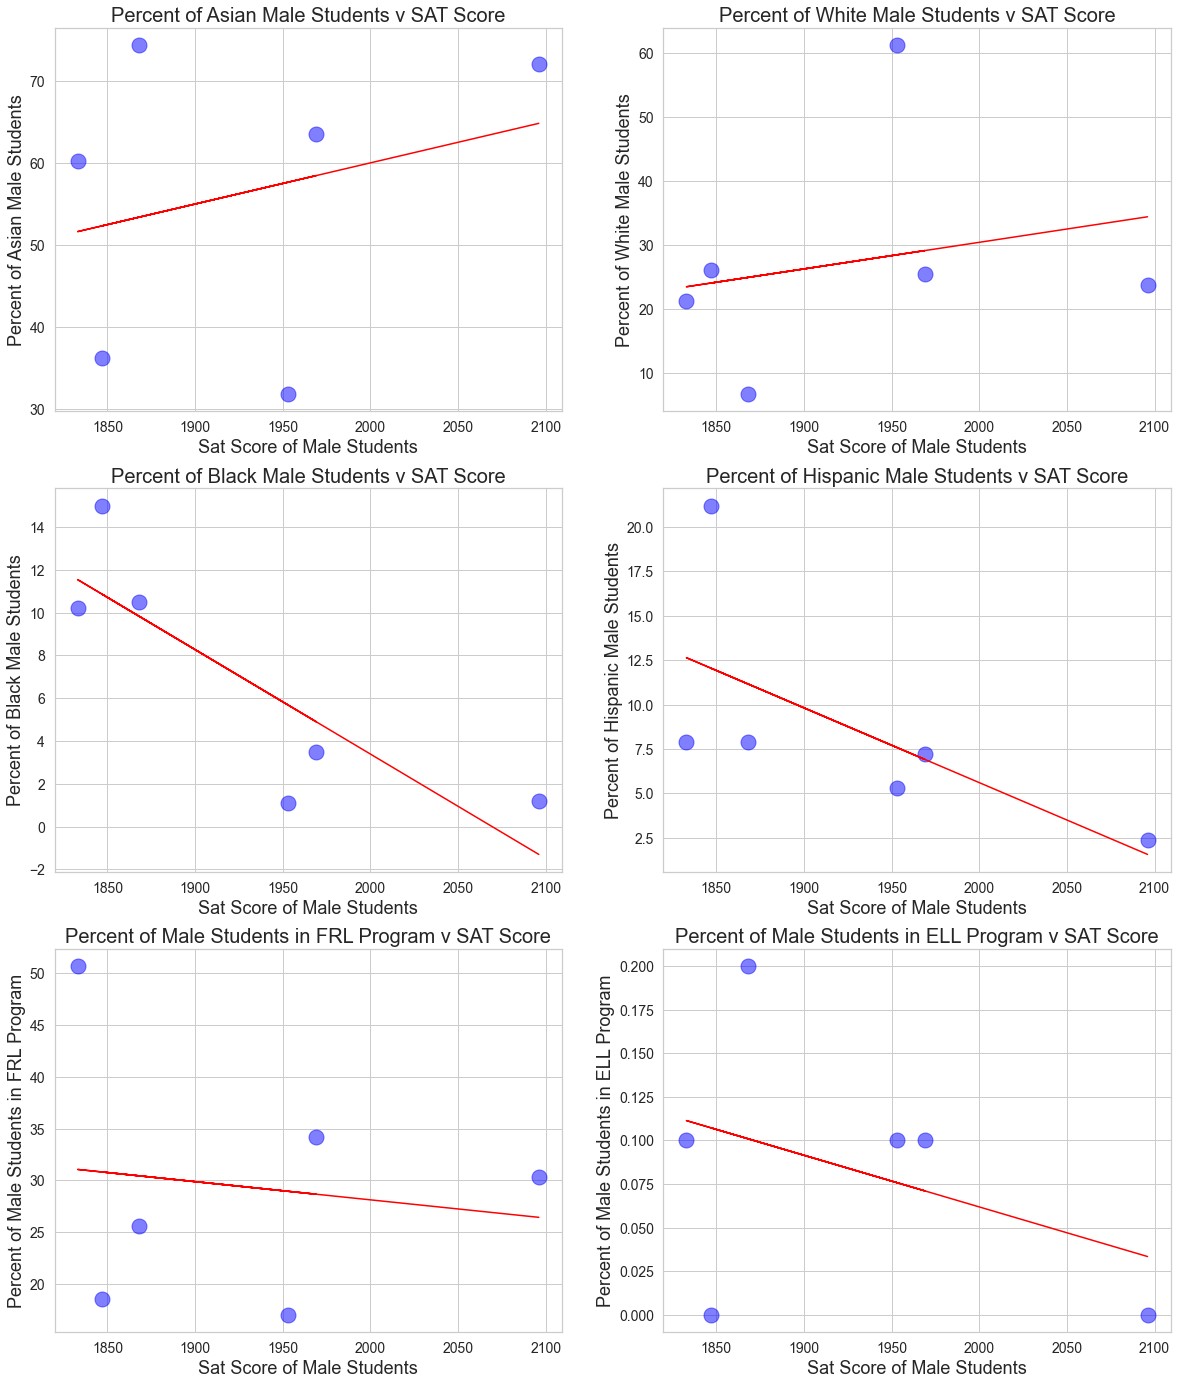

In [61]:
# Plotting the correlations using scatter plots
plt.figure(figsize=(20,24))

scattersubs(3, 2, 1, high_male_schools_data['sat_score'], high_male_schools_data['asian_per'],
           'blue', 'red', 'Percent of Asian Male Students v SAT Score',
           'Sat Score of Male Students', 
           'Percent of Asian Male Students')
scattersubs(3, 2, 2, high_male_schools_data['sat_score'], high_male_schools_data['white_per'],
           'blue', 'red', 'Percent of White Male Students v SAT Score',
           'Sat Score of Male Students', 
           'Percent of White Male Students')
scattersubs(3, 2, 3, high_male_schools_data['sat_score'], high_male_schools_data['black_per'],
           'blue', 'red', 'Percent of Black Male Students v SAT Score',
           'Sat Score of Male Students', 
           'Percent of Black Male Students')
scattersubs(3, 2, 4, high_male_schools_data['sat_score'], high_male_schools_data['hispanic_per'],
           'blue', 'red', 'Percent of Hispanic Male Students v SAT Score',
           'Sat Score of Male Students', 
           'Percent of Hispanic Male Students')
scattersubs(3, 2, 5, high_male_schools_data['sat_score'], high_male_schools_data['frl_percent'],
           'blue', 'red', 'Percent of Male Students in FRL Program v SAT Score',
           'Sat Score of Male Students', 
           'Percent of Male Students in FRL Program')
scattersubs(3, 2, 6, high_male_schools_data['sat_score'], high_male_schools_data['ell_percent'],
           'blue', 'red', 'Percent of Male Students in ELL Program v SAT Score',
           'Sat Score of Male Students', 
           'Percent of Male Students in ELL Program')
plt.show()

## Summary of male student percent vs. SAT scores:

+ The main takeaway is black and hispanic male students have a much higher negative correlation than female black and hispanic students.
+ Also ELL has a lower (negative) correlation with SAT in male students than in female students.

## Exploring AP Test Takers v SAT score

In [62]:
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100

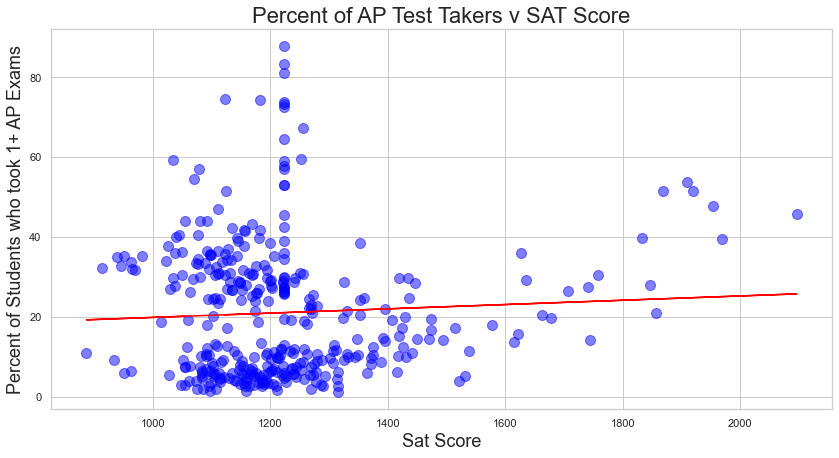

In [63]:
scatterplot(combined['sat_score'], combined['ap_per'], 'blue', 
            'Sat Score', 'Percent of Students who took 1+ AP Exams', 
            'Percent of AP Test Takers v SAT Score')

## Summary of AP Test Takers Percent v SAT score
From the above scatter plot, we can see there is a very slight positive correlation between students who took at least 1 AP Exam and SAT scores. What I find most interesting about the data, is that once the percent of test takers is above 55%, the SAT scores actually remain relatively low at around 1200. There seems to be kind of a sweet spot at between 20-55% where there are some schools with SAT scores above 1600. We can see from the plot that below 10% AP Exam takers typically don't do as well on the SATs with all below 1600 average, and the majority in the 1000-1300 range. The schools that do the best on the SATs (1800+) mostly have around 40-55% AP Test Takers.

Let's explore the schools that do best, a little further and see if there are any patterns.

In [64]:
ap_high_SAT_schools = combined[(combined['ap_per'] > .4) & (combined['sat_score'] > 1800)]

In [65]:
# separating just the 'SCHOOL NAME', 'sat_score', frl_percent' and 'ell_percent' columns
ap_high_SAT_schools_data = ap_high_SAT_schools[['SCHOOL NAME', 'sat_score', 'frl_percent', 'ell_percent', 'asian_per', 'white_per', 'black_per', 'hispanic_per']]
ap_high_SAT_schools_data = ap_high_SAT_schools_data.set_index('SCHOOL NAME')
ap_high_SAT_schools_data

,sat_score,frl_percent,ell_percent,asian_per,white_per,black_per,hispanic_per
SCHOOL NAME,,,,,,,
BARD HIGH SCHOOL EARLY COLLEGE,1856.0,18.0,0.2,15.1,49.8,15.1,18.2
STUYVESANT HIGH SCHOOL,2096.0,30.3,0.0,72.1,23.7,1.2,2.4
"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE",1847.0,18.5,0.0,36.2,26.1,15.0,21.2
BRONX HIGH SCHOOL OF SCIENCE,1969.0,34.2,0.1,63.5,25.4,3.5,7.2
HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,20.8,0.0,16.7,53.8,10.6,18.0
BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,50.7,0.1,60.3,21.3,10.2,7.9
TOWNSEND HARRIS HIGH SCHOOL,1910.0,29.2,0.0,55.5,24.6,5.9,12.9
QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE,1868.0,25.6,0.2,74.4,6.7,10.5,7.9
STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,17.0,0.1,31.8,61.3,1.1,5.3


In [66]:
# Creating a correlation DataFrame using 'sat_score' correlation with the above columns
ap_high_SAT_schools_data_corr = ap_high_SAT_schools_data.corr()['sat_score']
ap_high_SAT_schools_data_corr

sat_score       1.000000
frl_percent    -0.029271
ell_percent    -0.392298
asian_per       0.325140
white_per       0.068129
black_per      -0.813718
hispanic_per   -0.615969
Name: sat_score, dtype: float64

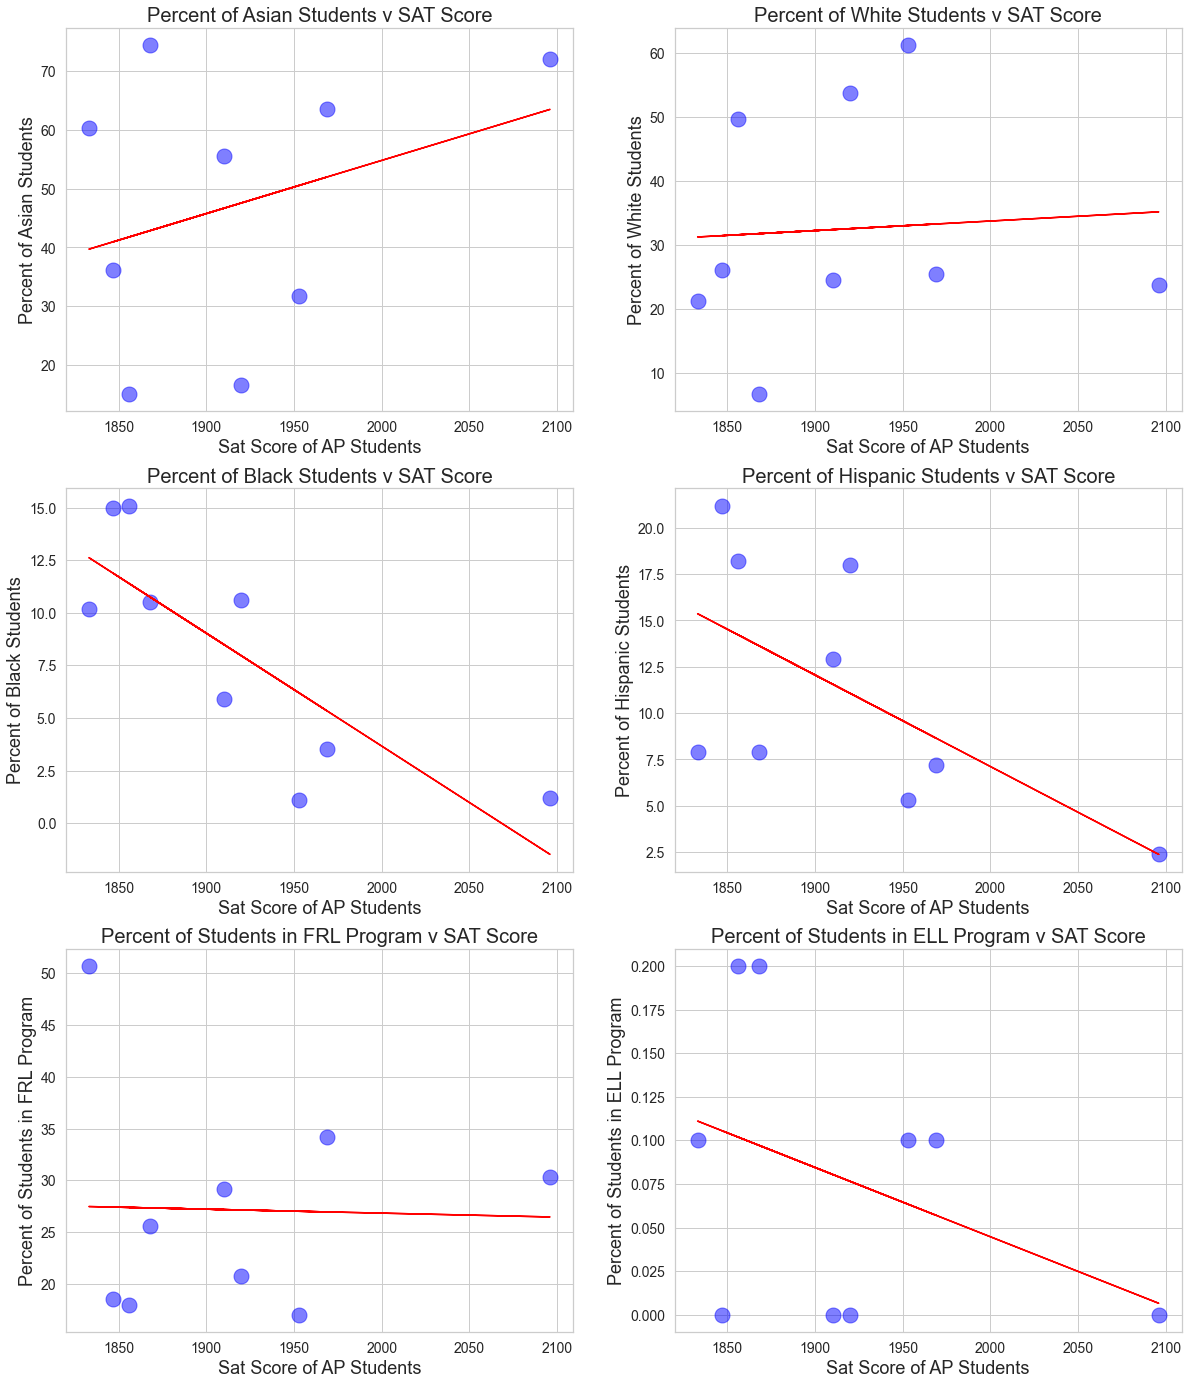

In [67]:
# Plotting the correlations using scatter plots
plt.figure(figsize=(20,24))

scattersubs(3, 2, 1, ap_high_SAT_schools_data['sat_score'], ap_high_SAT_schools_data['asian_per'],
           'blue', 'red', 'Percent of Asian Students v SAT Score',
           'Sat Score of AP Students', 
           'Percent of Asian Students')
scattersubs(3, 2, 2, ap_high_SAT_schools_data['sat_score'], ap_high_SAT_schools_data['white_per'],
           'blue', 'red', 'Percent of White Students v SAT Score',
           'Sat Score of AP Students', 
           'Percent of White Students')
scattersubs(3, 2, 3, ap_high_SAT_schools_data['sat_score'], ap_high_SAT_schools_data['black_per'],
           'blue', 'red', 'Percent of Black Students v SAT Score',
           'Sat Score of AP Students', 
           'Percent of Black Students')
scattersubs(3, 2, 4, ap_high_SAT_schools_data['sat_score'], ap_high_SAT_schools_data['hispanic_per'],
           'blue', 'red', 'Percent of Hispanic Students v SAT Score',
           'Sat Score of AP Students', 
           'Percent of Hispanic Students')
scattersubs(3, 2, 5, ap_high_SAT_schools_data['sat_score'], ap_high_SAT_schools_data['frl_percent'],
           'blue', 'red', 'Percent of Students in FRL Program v SAT Score',
           'Sat Score of AP Students', 
           'Percent of Students in FRL Program')
scattersubs(3, 2, 6, ap_high_SAT_schools_data['sat_score'], ap_high_SAT_schools_data['ell_percent'],
           'blue', 'red', 'Percent of Students in ELL Program v SAT Score',
           'Sat Score of AP Students', 
           'Percent of Students in ELL Program')
plt.show()

## Summary of schools with above 40% AP percent of students and SAT scores above 1800:

+ The main takeaway here is ELL students are nearly non-existant at these schools, with the highest percent of ELL being 0.20%.
+ Another takeaway is there are higher percentages of Asian and White students at these schools and they seem to have an advantage over Black and Hispanic students when it comes to SAT scores.
+ Black and Hispanic students have relatively high negative correlation with SAT scores at 0.74 and 0.60 respectively.

In [68]:
# Just so we can see which boroughs these schools are in:
ap_high_SAT_schools_boro = ap_high_SAT_schools[['SCHOOL NAME', 'sat_score', 'borough']]
ap_high_SAT_schools_boro

# There doesn't seem to be much pattern here besides Queens having 2 schools on the list

,SCHOOL NAME,sat_score,borough
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,Manhattan
37,STUYVESANT HIGH SCHOOL,2096.0,Manhattan
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,Manhattan
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,Bronx
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,Bronx
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,Brooklyn
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,Queens
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,Queens
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,Staten Island


## Exploring Asian percentages v SAT score

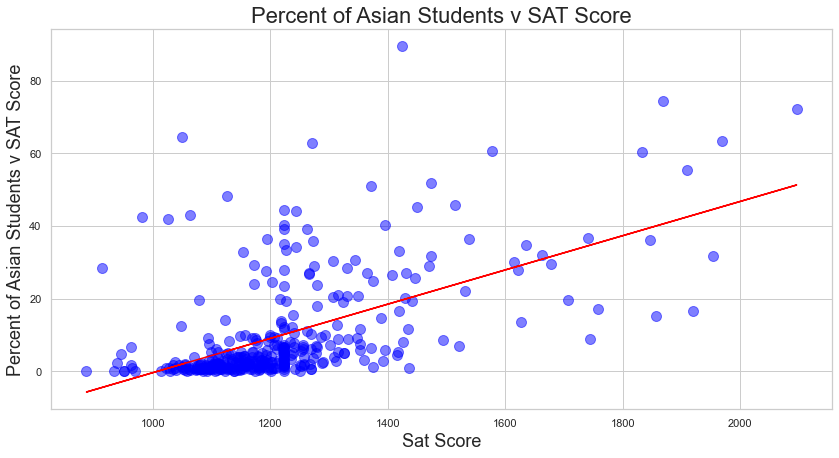

In [69]:
scatterplot(combined['sat_score'], combined['asian_per'], 'blue', 
            'Sat Score', 'Percent of Asian Students v SAT Score', 
            'Percent of Asian Students v SAT Score')
plt.show()

## Analyzing Asian percentage v. SAT score
There is a clear positive correlation between Asian percentage of student body vs. SAT score. We've noted this pattern already while analyzing other segments of the data, so let's explore it a little further.

In [70]:
asian_per_bronx = combined[(combined['asian_per'] > 40) & (combined['borough'] == 'Bronx')]

asian_per_brooklyn = combined[(combined['asian_per'] > 40) & (combined['borough'] == 'Brooklyn')]

asian_per_manhattan = combined[(combined['asian_per'] > 40) & (combined['borough'] == 'Manhattan')]

asian_per_statenisland = combined[(combined['asian_per'] > 40) & (combined['borough'] == 'Staten Island')]

asian_per_queens = combined[(combined['asian_per'] > 40) & (combined['borough'] == 'Queens')]

asian_per_boro = [asian_per_bronx, asian_per_brooklyn, asian_per_manhattan, asian_per_statenisland, asian_per_queens]

In [71]:
asian_schools_per_boro = [len(asian_per_bronx['SCHOOL NAME']), len(asian_per_brooklyn['SCHOOL NAME']), len(asian_per_manhattan['SCHOOL NAME']), len(asian_per_statenisland['SCHOOL NAME']), len(asian_per_queens['SCHOOL NAME'])]
asian_schools_per_boro

[1, 4, 5, 0, 11]

We can see the following breakdown from the above datasets:</br>
* Bronx = 1 school with > 40% Asian
* Brooklyn = 4 schools with > 40% Asian
* Manhattan = 5 schools with > 40% Asian
* Staten Island = 0 schools with > 40% Asian
* Queens = 11 schools with > 40% Asian

In [72]:
for boro in asian_per_boro:
    asian_schools_data = (boro[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']])
    print (asian_schools_data)

                      SCHOOL NAME  sat_score  asian_per  white_per  black_per  \
151  BRONX HIGH SCHOOL OF SCIENCE     1969.0       63.5       25.4        3.5   

     hispanic_per  frl_percent  ell_percent     ap_per  
151           7.2         34.2          0.1  39.495519  
                                SCHOOL NAME  sat_score  asian_per  white_per  \
187          BROOKLYN TECHNICAL HIGH SCHOOL     1833.0       60.3       21.3   
188      BROOKLYN INTERNATIONAL HIGH SCHOOL      981.0       42.5        8.7   
263   FRANKLIN DELANO ROOSEVELT HIGH SCHOOL     1244.0       44.2       18.6   
265  INTERNATIONAL HIGH SCHOOL AT LAFAYETTE     1026.0       42.0       22.7   

     black_per  hispanic_per  frl_percent  ell_percent     ap_per  
187       10.2           7.9         50.7          0.1  39.703676  
188       20.2          28.6         80.0         83.1  35.157724  
263        9.4          27.3         74.3         39.4   7.335907  
265       14.0          21.0         73.8         

In [73]:
# Calculating average SAT scores across all boroughs for schools with > 40% Asian student body

avg_sat_scores = round((asian_schools_data['sat_score']).agg(np.mean),2)
print ('Average SAT Scores across all boroughs (above 40% Asian):', avg_sat_scores)

avg_ell_per = round((asian_schools_data['ell_percent']).agg(np.mean),2)
print ('Average ELL percent across all boroughs (above 40% Asian):', avg_ell_per, '%')

avg_ap_per = round((asian_schools_data['ap_per']).agg(np.mean),2)
print ('Average AP percent across all boroughs (above 40% Asian):', avg_ap_per, '%')

Average SAT Scores across all boroughs (above 40% Asian): 1408.55
Average ELL percent across all boroughs (above 40% Asian): 27.12 %
Average AP percent across all boroughs (above 40% Asian): 24.94 %


In [74]:
asian_per_bronx = asian_per_bronx[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
asian_per_brooklyn = asian_per_brooklyn[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
asian_per_manhattan = asian_per_manhattan[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
asian_per_statenisland = asian_per_statenisland[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
asian_per_queens = asian_per_queens[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]

In [75]:
asian_per_bronx_corr = asian_per_bronx.corr()['sat_score']
asian_per_brooklyn_corr = asian_per_brooklyn.corr()['sat_score']
asian_per_manhattan = asian_per_manhattan.corr()['sat_score']
asian_per_statenisland = asian_per_statenisland.corr()['sat_score']
asian_per_queens = asian_per_queens.corr()['sat_score']

print ('Asian Percent Bronx:', asian_per_bronx_corr)
print ('\n')
print ('Asian Percent Brooklyn:', asian_per_brooklyn_corr)
print ('\n')
print ('Asian Percent Manhattan:', asian_per_manhattan)
print ('\n')
print ('Asian Percent Staten Island:', asian_per_statenisland)
print ('\n')
print ('Asian Percent Queens:', asian_per_queens)

Asian Percent Bronx: sat_score      NaN
asian_per      NaN
white_per      NaN
black_per      NaN
hispanic_per   NaN
frl_percent    NaN
ell_percent    NaN
ap_per         NaN
Name: sat_score, dtype: float64


Asian Percent Brooklyn: sat_score       1.000000
asian_per       0.979833
white_per       0.455668
black_per      -0.657648
hispanic_per   -0.874763
frl_percent    -0.969833
ell_percent    -0.959471
ap_per          0.151354
Name: sat_score, dtype: float64


Asian Percent Manhattan: sat_score       1.000000
asian_per       0.504843
white_per       0.882448
black_per      -0.816830
hispanic_per   -0.756342
frl_percent    -0.955570
ell_percent    -0.688287
ap_per         -0.270599
Name: sat_score, dtype: float64


Asian Percent Staten Island: sat_score      NaN
asian_per      NaN
white_per      NaN
black_per      NaN
hispanic_per   NaN
frl_percent    NaN
ell_percent    NaN
ap_per         NaN
Name: sat_score, dtype: float64


Asian Percent Queens: sat_score       1.000000
asian_per     

## Summary of schools with 'asian_per' above 40% per borough v. SAT score:
+ From the above data, we can see that there is a high negative correlation with ell_percent and low SAT scores, even when the student body is over 40% Asian. 
+ The highest scores are attributed to those schools with less than 10% English Language Learners (ELL), and the lowest scores to those with more than 80% ELL.
+ There is a big difference in how well each race does from borough to borough.
 + Asian students have the highest correlation with SAT scores in Brooklyn (for these schools), and only a slight positive correlation in Queens.
 
Let's explore the ell_percent and SAT score further.

## Exploring English Language Learners (ELL) v. SAT score:

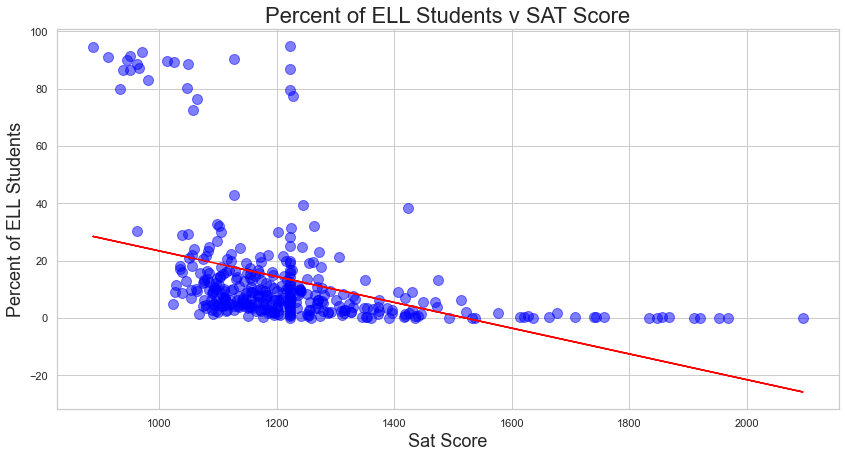

In [76]:
scatterplot(combined['sat_score'], combined['ell_percent'], 'blue', 
            'Sat Score', 'Percent of ELL Students', 
            'Percent of ELL Students v SAT Score')
plt.show()

In [77]:
ELL_SAT_corr = combined.corr()['sat_score']['ell_percent']
print ('The correlation between ELL percent and SAT scores is:', ELL_SAT_corr)

The correlation between ELL percent and SAT scores is: -0.39874973220852017


## Analyzing ELL percent v. SAT score:
We can see there is a negative correlation between the percent of ELL students in a school and SAT scores. There are no schools with above 40% ELL students that have more than a 1300 average SAT score. Only 1 school with close to 40% has more than 1400 average SAT score. This most likely indicates that the SAT is an unfair assessment for ELL students, especially since the SAT is only given in English and there may be many students who are not yet proficient in English by the time they take the SAT.

## Exploring ELL with Race v. SAT score

In [78]:
asian_per_ell = combined[(combined['asian_per'] > 40) & (combined['ell_percent'] > 60)]

white_per_ell = combined[(combined['white_per'] > 40) & (combined['ell_percent'] > 60)]

black_per_ell = combined[(combined['black_per'] > 40) & (combined['ell_percent'] > 60)]

hispanic_per_ell = combined[(combined['hispanic_per'] > 40) & (combined['ell_percent'] > 60)]

race_per_ell = [asian_per_ell, white_per_ell, black_per_ell, hispanic_per_ell]

In [79]:
race_per_ell_schools = [len(asian_per_ell['SCHOOL NAME']), len(white_per_ell['SCHOOL NAME']), len(black_per_ell['SCHOOL NAME']), len(hispanic_per_ell['SCHOOL NAME'])]
race_per_ell_schools

[6, 0, 0, 17]

+ There are 6 schools with >40% Asian student body and >60% ELL student percent.
+ 0 schools with >40% White or Black student body and >60% ELL student percent.
+ And 17 schools with >40% Hispanic student body and >60% ELL student percent.

In [80]:
for race in race_per_ell:
    race_ell_schools_data = (race[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']])
    print (race_ell_schools_data)

                                           SCHOOL NAME    sat_score  \
33           INTERNATIONAL HIGH SCHOOL AT UNION SQUARE  1223.438806   
188                 BROOKLYN INTERNATIONAL HIGH SCHOOL   981.000000   
265             INTERNATIONAL HIGH SCHOOL AT LAFAYETTE  1026.000000   
291  INTERNATIONAL HIGH SCHOOL AT LAGUARDIA COMMUNI...  1064.000000   
297                 FLUSHING INTERNATIONAL HIGH SCHOOL  1049.000000   
344                              NEWCOMERS HIGH SCHOOL  1127.000000   

     asian_per  white_per  black_per  hispanic_per  frl_percent  ell_percent  \
33        40.3        3.4       12.5          43.2         82.8         94.9   
188       42.5        8.7       20.2          28.6         80.0         83.1   
265       42.0       22.7       14.0          21.0         73.8         89.2   
291       43.0       10.3        2.0          44.0         75.7         76.5   
297       64.5        1.7        1.2          32.7         84.1         88.6   
344       48.3        

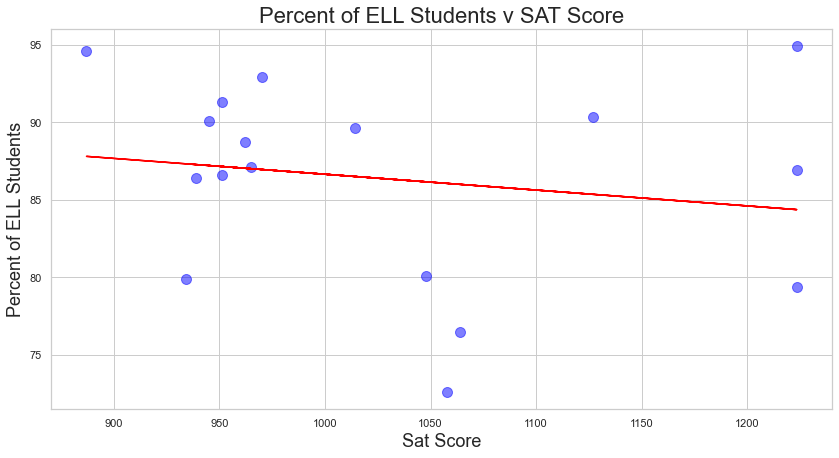

In [81]:
scatterplot(race_ell_schools_data['sat_score'], race_ell_schools_data['ell_percent'], 'blue', 
            'Sat Score', 'Percent of ELL Students', 
            'Percent of ELL Students v SAT Score')
plt.show()

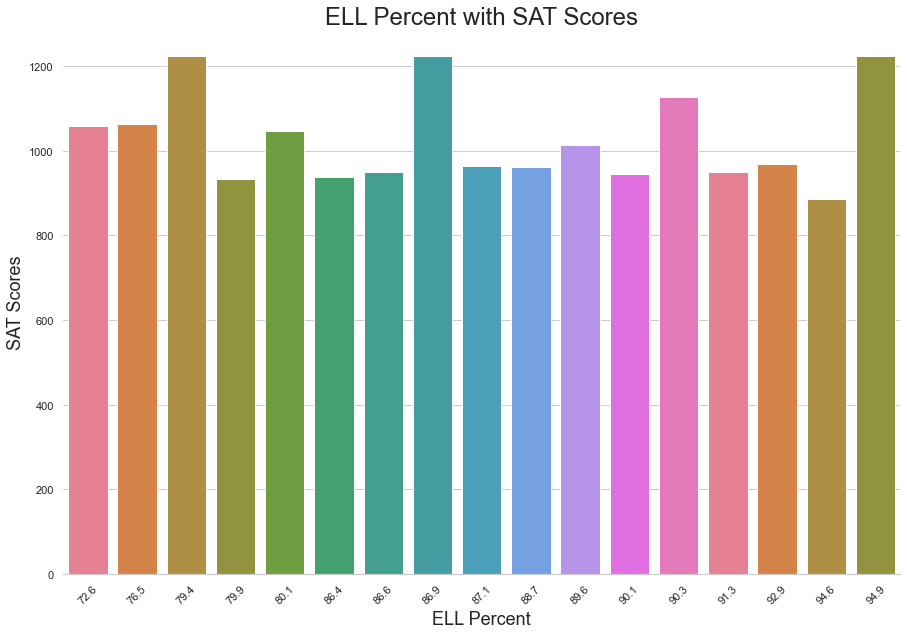

In [82]:
bargraph(race_ell_schools_data, race_ell_schools_data['ell_percent'], race_ell_schools_data['sat_score'], 
         'ELL Percent', 'SAT Scores', 'ELL Percent with SAT Scores')

## Summary of ELL Percent vs. SAT scores:

+ There is a slight negative correlation with ELL percent and SAT scores for these schools but actually we can see that for schools with high ELL (above 60%), the SAT score average does not go above 1223.44 which is relatively low.
+ There are some outliers in the data that are interesting, we can see in the above bar graph that some of the schools with very high ELL percent (86.9% and 94.9%) have some of the highest SAT scores within this group. While it's still not a high SAT score, it's still interesting that despite the very high ELL, the students got a higher average SAT score than others with lower ELL percent.

In [83]:
# Separating the schools with the highest SAT scores of the above group (high ELL)
hsat_ell_schools_data = race_ell_schools_data[(race_ell_schools_data['sat_score'] > 1200.0)]
print (hsat_ell_schools_data)

print ('\n')

# Separating the schools with the lowest SAT scores of the above group (high ELL)
lsat_ell_schools_data = race_ell_schools_data[(race_ell_schools_data['sat_score'] < 950.0)]
print (lsat_ell_schools_data)

                                   SCHOOL NAME    sat_score  asian_per  \
31       MANHATTAN ACADEMY FOR ARTS & LANGUAGE  1223.438806        6.3   
33   INTERNATIONAL HIGH SCHOOL AT UNION SQUARE  1223.438806       40.3   
111                  BRONX BRIDGES HIGH SCHOOL  1223.438806        5.2   

     white_per  black_per  hispanic_per  frl_percent  ell_percent     ap_per  
31         1.1        8.0          84.6         97.5         86.9  73.730769  
33         3.4       12.5          43.2         82.8         94.9  73.311844  
111        2.6        8.4          83.2         87.2         79.4  83.244417  


                               SCHOOL NAME  sat_score  asian_per  white_per  \
91     INTERNATIONAL COMMUNITY HIGH SCHOOL      945.0        4.8        2.0   
141  INTERNATIONAL SCHOOL FOR LIBERAL ARTS      934.0        0.2        0.0   
179          HIGH SCHOOL OF WORLD CULTURES      939.0        2.4        0.5   
253              MULTICULTURAL HIGH SCHOOL      887.0        0.0     

+ The International High School At Union Square has the highest ELL percent but also one of the highest SAT scores for the group. 
+ What's interesting is that the Asian percent is much higher here with 40.3%, which may account for the difference in SAT scores, despite the ELL percent.
+ All of the schools with below 950 SAT avg score have above 70% Hispanic student body, as well as above 79% ELL percent.
+ The lowest SAT scoring school is nearly 100% Hispanic and has 94.6% ELL percent which is the second highest ELL.
+ This indicates that both ELL and race play a role in SAT scores.

There may be something culturally that is driving the difference between Asian ELL students and Hispanic ELL students, or it may be environmental, or something unforeseen.

## Exploring Hispanic Percent vs. SAT Scores

In [84]:
hispanic_per_bronx = combined[(combined['hispanic_per'] > 40) & (combined['borough'] == 'Bronx')]

hispanic_per_brooklyn = combined[(combined['hispanic_per'] > 40) & (combined['borough'] == 'Brooklyn')]

hispanic_per_manhattan = combined[(combined['hispanic_per'] > 40) & (combined['borough'] == 'Manhattan')]

hispanic_per_statenisland = combined[(combined['hispanic_per'] > 40) & (combined['borough'] == 'Staten Island')]

hispanic_per_queens = combined[(combined['hispanic_per'] > 40) & (combined['borough'] == 'Queens')]

hispanic_per_boro = [hispanic_per_bronx, hispanic_per_brooklyn, hispanic_per_manhattan, hispanic_per_statenisland, hispanic_per_queens]

In [85]:
hispanic_schools_per_boro = [len(hispanic_per_bronx['SCHOOL NAME']), len(hispanic_per_brooklyn['SCHOOL NAME']), len(hispanic_per_manhattan['SCHOOL NAME']), len(hispanic_per_statenisland['SCHOOL NAME']), len(hispanic_per_queens['SCHOOL NAME'])]
hispanic_schools_per_boro

[87, 24, 67, 0, 23]

In [86]:
for boro in hispanic_per_boro:
    hispanic_schools_data = (boro[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']])
    print (hispanic_schools_data)

                                          SCHOOL NAME    sat_score  asian_per  \
90    SOUTH BRONX PREPARATORY: A COLLEGE BOARD SCHOOL  1090.000000        0.6   
91                INTERNATIONAL COMMUNITY HIGH SCHOOL   945.000000        4.8   
92                COMMUNITY SCHOOL FOR SOCIAL JUSTICE  1077.000000        0.6   
93         MOTT HAVEN VILLAGE PREPARATORY HIGH SCHOOL  1097.000000        1.1   
94                UNIVERSITY HEIGHTS SECONDARY SCHOOL  1201.000000        2.6   
..                                                ...          ...        ...   
178  BRONX CAREER AND COLLEGE PREPARATORY HIGH SCHOOL  1223.438806        2.5   
179                     HIGH SCHOOL OF WORLD CULTURES   939.000000        2.4   
180              FANNIE LOU HAMER FREEDOM HIGH SCHOOL  1029.000000        0.2   
181                                     WINGS ACADEMY  1114.000000        1.3   
182           MONROE ACADEMY FOR VISUAL ARTS & DESIGN  1038.000000        0.9   

     white_per  black_per  

In [87]:
# Calculating average SAT scores across all boroughs for schools with > 40% Hispanic student body

avg_sat_scores = round((hispanic_schools_data['sat_score']).agg(np.mean),2)
print ('Average SAT Scores across all boroughs (above 40% Hispanic):', avg_sat_scores)

avg_ell_per = round((hispanic_schools_data['ell_percent']).agg(np.mean),2)
print ('Average ELL percent across all boroughs (above 40% Hispanic):', avg_ell_per, '%')

avg_ap_per = round((hispanic_schools_data['ap_per']).agg(np.mean),2)
print ('Average AP percent across all boroughs (above 40% Hispanic):', avg_ap_per, '%')

Average SAT Scores across all boroughs (above 40% Hispanic): 1219.28
Average ELL percent across all boroughs (above 40% Hispanic): 20.83 %
Average AP percent across all boroughs (above 40% Hispanic): 16.03 %


In [88]:
hispanic_per_bronx = hispanic_per_bronx[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
hispanic_per_brooklyn = hispanic_per_brooklyn[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
hispanic_per_manhattan = hispanic_per_manhattan[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
hispanic_per_statenisland = hispanic_per_statenisland[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]
hispanic_per_queens = hispanic_per_queens[['SCHOOL NAME', 'sat_score', 'asian_per', 'white_per', 'black_per', 'hispanic_per', 'frl_percent', 'ell_percent', 'ap_per']]

In [89]:
hispanic_per_bronx_corr = hispanic_per_bronx.corr()['sat_score']
hispanic_per_brooklyn_corr = hispanic_per_brooklyn.corr()['sat_score']
hispanic_per_manhattan = hispanic_per_manhattan.corr()['sat_score']
hispanic_per_statenisland = hispanic_per_statenisland.corr()['sat_score']
hispanic_per_queens = hispanic_per_queens.corr()['sat_score']

print ('Hispanic Percent Bronx:', hispanic_per_bronx_corr)
print ('\n')
print ('Hispanic Percent Brooklyn:', hispanic_per_brooklyn_corr)
print ('\n')
print ('Hispanic Percent Manhattan:', hispanic_per_manhattan)
print ('\n')
print ('Hispanic Percent Staten Island:', hispanic_per_statenisland)
print ('\n')
print ('Hispanic Percent Queens:', hispanic_per_queens)

Hispanic Percent Bronx: sat_score       1.000000
asian_per       0.353890
white_per       0.375535
black_per       0.249838
hispanic_per   -0.421601
frl_percent    -0.442408
ell_percent    -0.617012
ap_per         -0.086463
Name: sat_score, dtype: float64


Hispanic Percent Brooklyn: sat_score       1.000000
asian_per       0.418398
white_per       0.389949
black_per       0.130887
hispanic_per   -0.384028
frl_percent    -0.108754
ell_percent    -0.738169
ap_per         -0.243639
Name: sat_score, dtype: float64


Hispanic Percent Manhattan: sat_score       1.000000
asian_per       0.475533
white_per       0.483364
black_per       0.034416
hispanic_per   -0.421920
frl_percent    -0.502089
ell_percent    -0.379693
ap_per         -0.087001
Name: sat_score, dtype: float64


Hispanic Percent Staten Island: sat_score      NaN
asian_per      NaN
white_per      NaN
black_per      NaN
hispanic_per   NaN
frl_percent    NaN
ell_percent    NaN
ap_per         NaN
Name: sat_score, dtype: float64


H

## Summary of schools with 'hispanic_per' above 40% per borough v. SAT score:

+ Hispanic students at schools with above 40% Hispanic student body have a negative correlation with SAT scores in every borough.
+ A very surprising point in this data is that ELL percent is lower in these schools than in the >40% Asian schools.
+ Even when ELL percent is not highly negatively correlated with SAT scores, Hispanic students still have about the same negative correlation with SAT scores.
+ Oddly, AP percent has a negative correlation with SAT scores for these schools.
+ SAT scores on average are much lower for these schools than the 40%+ Asian schools by borough.

## Final Analysis/Conclusion of Student Demographics/Survey Catagories vs. SAT Scores:

+ There is a clear negative relationship between ELL students and the SAT scores.
+ Another clear negative relationship is between FRL enrolled students and SAT scores.
+ On average, Asian and White students have an advantage over Black and Hispanic students when it comes to SAT scores in NYC.
+ Schools with the highest SAT scores are ones with between 40-75% female student body, or between 30-70% male student body
+ Both ELL and race (namely Asian and Hispanic) play a role in average SAT scores for schools.
+ While ELL overall negatively correlates with SAT, Asian ELL students tend to do better on average than Hispanic ELL students on the SATs.
+ While AP Test Takers generally have a fairly positive correlation with SAT scores, they have a slightly negative correlation with SAT scores in schools with high Hispanic and ELL percent, and in Manhattan in schools with high Asian and ELL percent.

It's important to note that this study does not have enough data available to be able to drill down further on why race plays a role in the SATs, only that it does. This is not an indication that any race is more or less intelligent than another, it is merely an observational data point and there can be many contributing factors in the reasons behind these differences. In order to further study this, we would need to look into students' enviromental and cultural differences, neighborhoods, parents' education, family income, student employment, history, etc.

Some of the factors of this disparage may be due to parental help or encouragement in the home/involvement in students academia, it could be due to economic disadvantagement being a hinderance to academia, and may affect some races differently than others (i.e. - if one race/culture is more likely to ask students to work to help their family, where another might place more importance on academia even if they are economically disadvantaged), but it needs further study to know for sure what is driving the differences. One thing seems to be for sure, and that is that language barriers (ELL) definitely have a major impact on SAT scores, and possibly on academia in general. 

It is also clear that economic disadvantagement contributes to lower SAT scores (FRL enrollment shows economic disadvantagement). This could also be due to a number of factors, and would need further study. Some factors may be biological, as there are studies that nutrition and nurishment directly affect the brain and may affect the ability to learn and retain information. While these students may be provided meals at school, we don't know what their nutrition is like in their home but we know from other studies that often lower-income neighborhoods are in the middle of 'food deserts'. Another factor could be that economic disadvantagement usually goes hand-in-hand with other disadvantages such as single-parent homes, parents working multiple jobs (less time spent with students), student employment (working to help their family), lower-income neighborhoods with higher rates of crime (less safety and stability in environment, poor influences, less importance placed on academia and more importance placed on survival, not enough community resources), etc.

The data we've analyzed in this project shows us that the SAT exams do not seem to be a fair assessment for all students. We can clearly see that students who are learning English as a second language, as well as Hispanic and Black students are at a disadvantage when it comes to SATs. We can also see that economic disadvantagement places students at an academic disadvantage. Schools with more than 75% female student body and more than 70% male student body also do worse on average than schools with between 40-75% female or 30-70% male student body. Further study would help us understand the reasons behind all these differences. In general, it would seem that there needs to be either a different system to measure students' academic retention/performance or there needs to be changes made to the SATs to ensure fairness.